In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Mounted at /content/drive/


In [114]:
data1 = pd.read_csv('../../data/stock_at_weekly_level.csv')

In [115]:
data1.head()

,Unnamed: 0,StockCode,week_start,Quantity,week_no,wom,year
0,0,10002,2009-01-12,12.0,3,1,2009
1,1,10002,2009-01-19,0.0,4,2,2009
2,2,10002,2009-01-26,0.0,5,3,2009
3,3,10002,2009-02-02,0.0,6,0,2009
4,4,10002,2009-02-09,0.0,7,1,2009


In [116]:
data1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [117]:
data1['ds'] = pd.to_datetime(data1['week_start'])

In [118]:
data1.drop(['week_start'],axis=1,inplace=True)

In [119]:
data1 = data1.loc[data1['year'] > 2009,]

In [120]:
data1.head(10)

,StockCode,Quantity,week_no,wom,year,ds
51,10002,451.000000,1,0,2010,2010-01-04
52,10002,133.000000,2,1,2010,2010-01-11
53,10002,32.000000,3,2,2010,2010-01-18
54,10002,23.666667,4,3,2010,2010-01-25
55,10002,3.333333,5,0,2010,2010-02-01
56,10002,7.500000,6,1,2010,2010-02-08
57,10002,13.000000,7,2,2010,2010-02-15
58,10002,161.000000,8,3,2010,2010-02-22
59,10002,272.000000,9,0,2010,2010-03-01
60,10002,14.666667,10,1,2010,2010-03-08


In [121]:
mu = data1.groupby(['StockCode'])['Quantity'].mean().reset_index()

In [122]:
mu = mu.rename(columns={'Quantity':'mean'})

In [123]:
std = data1.groupby(['StockCode'])['Quantity'].std().reset_index()
std = std.rename(columns={'Quantity':'std'})
data1 = data1.merge(mu,on=['StockCode'],how='left')
data1 = data1.merge(std,on=['StockCode'],how='left')
data1['tQuantity'] = (data1['Quantity'] - data1['mean'])/(data1['std'])

In [124]:
data = data1.copy()
data['lag1'] = data.groupby('StockCode')['tQuantity'].shift(1)
data['lag4'] = data.groupby('StockCode')['tQuantity'].shift(4)
data['lag52'] = data.groupby('StockCode')['tQuantity'].shift(52)

In [125]:
data.dropna(inplace=True)

In [126]:
data.shape

(141492, 12)

In [127]:
max_date = pd.to_datetime(data['ds']).max()
mx1_dt = (max_date - pd.to_timedelta(7, unit='w'))

In [128]:
mx1_dt

Timestamp('2011-09-12 00:00:00')

In [129]:
data['ds'] = pd.to_datetime(data['ds'])
train = data.loc[data['ds'] <= mx1_dt,]

In [130]:
val = data.loc[data['ds'] > mx1_dt,]
val_f = val[[x for x in val.columns if x not in ['tQuantity','Quantity','mean',]]]
val_f.index = val['ds']
val_f = val_f.drop(['ds'],axis=1)

In [131]:
train_f = train[[x for x in train.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
train_f.index = train.ds
train_f = train_f.drop(['ds'],axis=1)

In [132]:
mx_dt = (train['ds'].max() - pd.to_timedelta(6, unit='w'))

In [133]:
mx_dt

Timestamp('2011-08-01 00:00:00')

In [134]:
train1 = train.loc[train['ds'] <= mx_dt,]
train1.index = train1['ds']
train1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
val1 = train.loc[train['ds'] >  mx_dt,]

In [136]:
val1.index = val1['ds']
val1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [137]:
val1.index.max()

Timestamp('2011-09-12 00:00:00')

In [138]:
test = data.loc[data['ds'] > val1.index.max(),]
test.index = test['ds']
test.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [139]:
train_x = train1[[x for x in train1.columns if x not in ['tQuantity','Quantity','mean']]]
train_y = train1['tQuantity']

In [140]:
! pip install category_encoders

In [141]:
import category_encoders as ce
id_encoder =  ce.OrdinalEncoder()
id_encoder.fit(train_x['StockCode'])
train_x['id_cat'] = id_encoder.transform(train_x['StockCode'])
train_x1 = train_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [142]:
val_x = val1[[x for x in val1.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
val_y = val1['tQuantity']

In [143]:
val_x['id_cat'] = id_encoder.transform(val_x['StockCode'])
val_x1 = val_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [144]:
test_x = test[[x for x in test.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
test_x['id_cat'] = id_encoder.transform(test_x['StockCode'])
test_x1 = test_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [145]:
train_f['id_cat'] = id_encoder.transform(train_f['StockCode'])
train_f = train_f.drop(['StockCode'],axis=1)

In [146]:
train_fy = train['tQuantity']

In [147]:
val_f['id_cat'] = id_encoder.transform(val_f['StockCode'])
val_f.drop(['StockCode'],axis=1,inplace=True)
val_fy = val['tQuantity']

In [148]:
! pip install optuna

In [149]:
import optuna
import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import LightGBMTuner

In [150]:
params = {
    'objective': 'regression',
    'boosting_type':'gbdt',
    "eval_metric":'mse',
    'metric':'mse'
}

In [151]:
train_x1.columns.tolist()

['week_no', 'wom', 'year', 'std', 'lag1', 'lag4', 'lag52', 'id_cat']

In [152]:
categorical_feature = ['week_no','wom','id_cat']

In [153]:
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [154]:
tuned_model = LightGBMTuner(params, train_set=lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=300,
                                     early_stopping_rounds=30,
                                    )

[I 2021-02-19 18:56:00,817] A new study created in memory with name: no-name-a408eca7-6691-436f-9920-96196ff521b5


In [155]:
tuned_model.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l2: 0.649332
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.648901
[3]	valid_0's l2: 0.645416
[4]	valid_0's l2: 0.642872
[5]	valid_0's l2: 0.641098
[6]	valid_0's l2: 0.640191
[7]	valid_0's l2: 0.641314
[8]	valid_0's l2: 0.640747
[9]	valid_0's l2: 0.640499
[10]	valid_0's l2: 0.643042
[11]	valid_0's l2: 0.643621
[12]	valid_0's l2: 0.644317
[13]	valid_0's l2: 0.646492
[14]	valid_0's l2: 0.647517
[15]	valid_0's l2: 0.647653
[16]	valid_0's l2: 0.649647
[17]	valid_0's l2: 0.64963
[18]	valid_0's l2: 0.650172
[19]	valid_0's l2: 0.65148
[20]	valid_0's l2: 0.651225
[21]	valid_0's l2: 0.651108
[22]	valid_0's l2: 0.651159
[23]	valid_0's l2: 0.651498
[24]	valid_0's l2: 0.65136
[25]	valid_0's l2: 0.651857
[26]	valid_0's l2: 0.652137
[27]	valid_0's l2: 0.652309
[28]	valid_0's l2: 0.652703
[29]	valid_0's l2: 0.653177
[30]	valid_0's l2: 0.652915
[31]	valid_0's l2: 0.652816


feature_fraction, val_score: 0.640191:  14%|#4        | 1/7 [00:00<00:05,  1.08it/s]

[32]	valid_0's l2: 0.652897
[33]	valid_0's l2: 0.653396
[34]	valid_0's l2: 0.653491
[35]	valid_0's l2: 0.653712
[36]	valid_0's l2: 0.654047
Early stopping, best iteration is:
[6]	valid_0's l2: 0.640191
[1]	valid_0's l2: 0.650412
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.647693
[3]	valid_0's l2: 0.644444
[4]	valid_0's l2: 0.642564
[5]	valid_0's l2: 0.64114
[6]	valid_0's l2: 0.641096
[7]	valid_0's l2: 0.641417
[8]	valid_0's l2: 0.639243
[9]	valid_0's l2: 0.639403
[10]	valid_0's l2: 0.64135
[11]	valid_0's l2: 0.640628
[12]	valid_0's l2: 0.641251
[13]	valid_0's l2: 0.641064
[14]	valid_0's l2: 0.641684
[15]	valid_0's l2: 0.641134
[16]	valid_0's l2: 0.640602
[17]	valid_0's l2: 0.641183
[18]	valid_0's l2: 0.641078
[19]	valid_0's l2: 0.640557
[20]	valid_0's l2: 0.64042
[21]	valid_0's l2: 0.641057
[22]	valid_0's l2: 0.641958
[23]	valid_0's l2: 0.642772
[24]	valid_0's l2: 0.642896
[25]	valid_0's l2: 0.643644
[26]	valid_0's l2: 0.644369
[27]	valid_0's l2: 0

feature_fraction, val_score: 0.639243:  29%|##8       | 2/7 [00:01<00:04,  1.17it/s]

[31]	valid_0's l2: 0.64579
[32]	valid_0's l2: 0.645622
[33]	valid_0's l2: 0.647227
[34]	valid_0's l2: 0.648405
[35]	valid_0's l2: 0.648407
[36]	valid_0's l2: 0.649524
[37]	valid_0's l2: 0.649393
[38]	valid_0's l2: 0.650038
Early stopping, best iteration is:
[8]	valid_0's l2: 0.639243
[1]	valid_0's l2: 0.650412
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.647693
[3]	valid_0's l2: 0.644444
[4]	valid_0's l2: 0.642564
[5]	valid_0's l2: 0.64114
[6]	valid_0's l2: 0.641096
[7]	valid_0's l2: 0.641417
[8]	valid_0's l2: 0.639243
[9]	valid_0's l2: 0.639403
[10]	valid_0's l2: 0.64135
[11]	valid_0's l2: 0.640628
[12]	valid_0's l2: 0.641251
[13]	valid_0's l2: 0.641064
[14]	valid_0's l2: 0.641684
[15]	valid_0's l2: 0.641134
[16]	valid_0's l2: 0.640602
[17]	valid_0's l2: 0.641183
[18]	valid_0's l2: 0.641078
[19]	valid_0's l2: 0.640557
[20]	valid_0's l2: 0.64042
[21]	valid_0's l2: 0.641057
[22]	valid_0's l2: 0.641958
[23]	valid_0's l2: 0.642772
[24]	valid_0's l2: 0.

feature_fraction, val_score: 0.639243:  43%|####2     | 3/7 [00:02<00:03,  1.24it/s]


[33]	valid_0's l2: 0.647227
[34]	valid_0's l2: 0.648405
[35]	valid_0's l2: 0.648407
[36]	valid_0's l2: 0.649524
[37]	valid_0's l2: 0.649393
[38]	valid_0's l2: 0.650038
Early stopping, best iteration is:
[8]	valid_0's l2: 0.639243
[1]	valid_0's l2: 0.64727
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644818
[3]	valid_0's l2: 0.641774
[4]	valid_0's l2: 0.641853
[5]	valid_0's l2: 0.641635
[6]	valid_0's l2: 0.641587
[7]	valid_0's l2: 0.641578
[8]	valid_0's l2: 0.63961
[9]	valid_0's l2: 0.639965
[10]	valid_0's l2: 0.63867
[11]	valid_0's l2: 0.638006
[12]	valid_0's l2: 0.638202
[13]	valid_0's l2: 0.63776
[14]	valid_0's l2: 0.636444
[15]	valid_0's l2: 0.635464
[16]	valid_0's l2: 0.635582
[17]	valid_0's l2: 0.635252
[18]	valid_0's l2: 0.634934
[19]	valid_0's l2: 0.634543
[20]	valid_0's l2: 0.635062
[21]	valid_0's l2: 0.635229
[22]	valid_0's l2: 0.63526
[23]	valid_0's l2: 0.635042
[24]	valid_0's l2: 0.634376
[25]	valid_0's l2: 0.634414
[26]	valid_0's l2: 0.

feature_fraction, val_score: 0.633841:  57%|#####7    | 4/7 [00:03<00:02,  1.20it/s]

[64]	valid_0's l2: 0.638816
[65]	valid_0's l2: 0.638814
[66]	valid_0's l2: 0.638737
[67]	valid_0's l2: 0.63865
[68]	valid_0's l2: 0.639096
[69]	valid_0's l2: 0.639137
[70]	valid_0's l2: 0.639279
[71]	valid_0's l2: 0.640077
[72]	valid_0's l2: 0.640298
[73]	valid_0's l2: 0.640323
[74]	valid_0's l2: 0.640489
[75]	valid_0's l2: 0.640527
[76]	valid_0's l2: 0.640781
Early stopping, best iteration is:
[46]	valid_0's l2: 0.633841
[1]	valid_0's l2: 0.646578
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.642607
[3]	valid_0's l2: 0.642292
[4]	valid_0's l2: 0.642405
[5]	valid_0's l2: 0.641903
[6]	valid_0's l2: 0.639827
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.638412
[9]	valid_0's l2: 0.639262
[10]	valid_0's l2: 0.638863
[11]	valid_0's l2: 0.639135
[12]	valid_0's l2: 0.638752
[13]	valid_0's l2: 0.637658
[14]	valid_0's l2: 0.637657
[15]	valid_0's l2: 0.638745
[16]	valid_0's l2: 0.64102
[17]	valid_0's l2: 0.640482
[18]	valid_0's l2: 0.641076
[19]	valid_0's l2:

feature_fraction, val_score: 0.633841:  71%|#######1  | 5/7 [00:03<00:01,  1.26it/s]

[35]	valid_0's l2: 0.640265
[36]	valid_0's l2: 0.640293
[37]	valid_0's l2: 0.640499
[38]	valid_0's l2: 0.641781
[39]	valid_0's l2: 0.642607
[40]	valid_0's l2: 0.643076
[41]	valid_0's l2: 0.645157
[42]	valid_0's l2: 0.645641
[43]	valid_0's l2: 0.645753
[44]	valid_0's l2: 0.645778
Early stopping, best iteration is:
[14]	valid_0's l2: 0.637657
[1]	valid_0's l2: 0.649332
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.648344
[3]	valid_0's l2: 0.648112
[4]	valid_0's l2: 0.648722
[5]	valid_0's l2: 0.647116
[6]	valid_0's l2: 0.648942
[7]	valid_0's l2: 0.648169
[8]	valid_0's l2: 0.648089
[9]	valid_0's l2: 0.649786
[10]	valid_0's l2: 0.650247
[11]	valid_0's l2: 0.651652
[12]	valid_0's l2: 0.652869
[13]	valid_0's l2: 0.653368
[14]	valid_0's l2: 0.653731
[15]	valid_0's l2: 0.653915
[16]	valid_0's l2: 0.653844
[17]	valid_0's l2: 0.65427
[18]	valid_0's l2: 0.656839
[19]	valid_0's l2: 0.657259
[20]	valid_0's l2: 0.657769
[21]	valid_0's l2: 0.658792
[22]	valid_0's l2

feature_fraction, val_score: 0.633841:  86%|########5 | 6/7 [00:04<00:00,  1.20it/s]


[29]	valid_0's l2: 0.663088
[30]	valid_0's l2: 0.663286
[31]	valid_0's l2: 0.663042
[32]	valid_0's l2: 0.663301
[33]	valid_0's l2: 0.665006
[34]	valid_0's l2: 0.665223
[35]	valid_0's l2: 0.665196
Early stopping, best iteration is:
[5]	valid_0's l2: 0.647116
[1]	valid_0's l2: 0.650412
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.647355
[3]	valid_0's l2: 0.644269
[4]	valid_0's l2: 0.642575
[5]	valid_0's l2: 0.641724
[6]	valid_0's l2: 0.641906
[7]	valid_0's l2: 0.640982
[8]	valid_0's l2: 0.638892
[9]	valid_0's l2: 0.641056
[10]	valid_0's l2: 0.642679
[11]	valid_0's l2: 0.642616
[12]	valid_0's l2: 0.644494
[13]	valid_0's l2: 0.645536
[14]	valid_0's l2: 0.646029
[15]	valid_0's l2: 0.645839
[16]	valid_0's l2: 0.64603
[17]	valid_0's l2: 0.647058
[18]	valid_0's l2: 0.647455
[19]	valid_0's l2: 0.647897
[20]	valid_0's l2: 0.64842
[21]	valid_0's l2: 0.648916
[22]	valid_0's l2: 0.648897
[23]	valid_0's l2: 0.64935
[24]	valid_0's l2: 0.649916
[25]	valid_0's l2: 

num_leaves, val_score: 0.633841:   0%|          | 0/20 [00:00<?, ?it/s]

[33]	valid_0's l2: 0.652823
[34]	valid_0's l2: 0.653604
[35]	valid_0's l2: 0.653631
[36]	valid_0's l2: 0.654986
[37]	valid_0's l2: 0.655479
[38]	valid_0's l2: 0.655639
Early stopping, best iteration is:
[8]	valid_0's l2: 0.638892
[1]	valid_0's l2: 0.647292
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644858
[3]	valid_0's l2: 0.640598
[4]	valid_0's l2: 0.640484
[5]	valid_0's l2: 0.639952
[6]	valid_0's l2: 0.640016
[7]	valid_0's l2: 0.639669
[8]	valid_0's l2: 0.637102
[9]	valid_0's l2: 0.637527
[10]	valid_0's l2: 0.636362
[11]	valid_0's l2: 0.635737
[12]	valid_0's l2: 0.63601
[13]	valid_0's l2: 0.63568
[14]	valid_0's l2: 0.634156
[15]	valid_0's l2: 0.633326
[16]	valid_0's l2: 0.633448
[17]	valid_0's l2: 0.633013
[18]	valid_0's l2: 0.632549
[19]	valid_0's l2: 0.632775
[20]	valid_0's l2: 0.633438
[21]	valid_0's l2: 0.633582
[22]	valid_0's l2: 0.633744
[23]	valid_0's l2: 0.633573
[24]	valid_0's l2: 0.633045
[25]	valid_0's l2: 0.63321
[26]	valid_0's l2: 0

num_leaves, val_score: 0.632549:   5%|5         | 1/20 [00:01<00:18,  1.00it/s]

[33]	valid_0's l2: 0.636414
[34]	valid_0's l2: 0.636846
[35]	valid_0's l2: 0.636576
[36]	valid_0's l2: 0.636585
[37]	valid_0's l2: 0.63651
[38]	valid_0's l2: 0.636482
[39]	valid_0's l2: 0.636627
[40]	valid_0's l2: 0.636741
[41]	valid_0's l2: 0.636763
[42]	valid_0's l2: 0.636735
[43]	valid_0's l2: 0.636763
[44]	valid_0's l2: 0.636947
[45]	valid_0's l2: 0.636957
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637329
[48]	valid_0's l2: 0.637229
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632549
[1]	valid_0's l2: 0.647265
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644823
[3]	valid_0's l2: 0.641131
[4]	valid_0's l2: 0.641159
[5]	valid_0's l2: 0.640857
[6]	valid_0's l2: 0.640823
[7]	valid_0's l2: 0.640925
[8]	valid_0's l2: 0.638354
[9]	valid_0's l2: 0.638769
[10]	valid_0's l2: 0.637478
[11]	valid_0's l2: 0.636868
[12]	valid_0's l2: 0.63708
[13]	valid_0's l2: 0.636726
[14]	valid_0's l2: 0.635236
[15]	valid_0's l2: 0.634325
[16]	valid_0's l2:

num_leaves, val_score: 0.632549:  10%|#         | 2/20 [00:01<00:17,  1.05it/s]

[50]	valid_0's l2: 0.636235
[51]	valid_0's l2: 0.637368
[52]	valid_0's l2: 0.637324
[53]	valid_0's l2: 0.637352
[54]	valid_0's l2: 0.637292
Early stopping, best iteration is:
[24]	valid_0's l2: 0.633094
[1]	valid_0's l2: 0.647308
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644889
[3]	valid_0's l2: 0.640581
[4]	valid_0's l2: 0.640506
[5]	valid_0's l2: 0.639832
[6]	valid_0's l2: 0.640164
[7]	valid_0's l2: 0.640304
[8]	valid_0's l2: 0.637904
[9]	valid_0's l2: 0.638096
[10]	valid_0's l2: 0.636976
[11]	valid_0's l2: 0.636359
[12]	valid_0's l2: 0.636722
[13]	valid_0's l2: 0.636361
[14]	valid_0's l2: 0.634914
[15]	valid_0's l2: 0.634135
[16]	valid_0's l2: 0.634233
[17]	valid_0's l2: 0.633906
[18]	valid_0's l2: 0.63348
[19]	valid_0's l2: 0.633562
[20]	valid_0's l2: 0.633918
[21]	valid_0's l2: 0.63405
[22]	valid_0's l2: 0.634169
[23]	valid_0's l2: 0.633997
[24]	valid_0's l2: 0.633582
[25]	valid_0's l2: 0.633738
[26]	valid_0's l2: 0.634279
[27]	valid_0's l2:

num_leaves, val_score: 0.632549:  15%|#5        | 3/20 [00:02<00:16,  1.01it/s]

[44]	valid_0's l2: 0.637836
[45]	valid_0's l2: 0.637877
[46]	valid_0's l2: 0.637803
[47]	valid_0's l2: 0.63818
[48]	valid_0's l2: 0.638156
Early stopping, best iteration is:
[18]	valid_0's l2: 0.63348
[1]	valid_0's l2: 0.647234
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644796
[3]	valid_0's l2: 0.641159
[4]	valid_0's l2: 0.641185
[5]	valid_0's l2: 0.640871
[6]	valid_0's l2: 0.640851
[7]	valid_0's l2: 0.64089
[8]	valid_0's l2: 0.638327
[9]	valid_0's l2: 0.63869
[10]	valid_0's l2: 0.637423
[11]	valid_0's l2: 0.636812
[12]	valid_0's l2: 0.637014
[13]	valid_0's l2: 0.636518
[14]	valid_0's l2: 0.635099
[15]	valid_0's l2: 0.634189
[16]	valid_0's l2: 0.634285
[17]	valid_0's l2: 0.633548
[18]	valid_0's l2: 0.633292
[19]	valid_0's l2: 0.633185
[20]	valid_0's l2: 0.633642
[21]	valid_0's l2: 0.633775
[22]	valid_0's l2: 0.633978
[23]	valid_0's l2: 0.633885
[24]	valid_0's l2: 0.633199
[25]	valid_0's l2: 0.63324
[26]	valid_0's l2: 0.634221
[27]	valid_0's l2: 0.

num_leaves, val_score: 0.632549:  20%|##        | 4/20 [00:03<00:14,  1.10it/s]

[33]	valid_0's l2: 0.636045
[34]	valid_0's l2: 0.636549
[35]	valid_0's l2: 0.636069
[36]	valid_0's l2: 0.635957
[37]	valid_0's l2: 0.635906
[38]	valid_0's l2: 0.635705
[39]	valid_0's l2: 0.635529
[40]	valid_0's l2: 0.635471
[41]	valid_0's l2: 0.635414
[42]	valid_0's l2: 0.63535
[43]	valid_0's l2: 0.635277
[44]	valid_0's l2: 0.635333
[45]	valid_0's l2: 0.635314
[46]	valid_0's l2: 0.635155
[47]	valid_0's l2: 0.635651
[48]	valid_0's l2: 0.635627
[49]	valid_0's l2: 0.635614
Early stopping, best iteration is:
[19]	valid_0's l2: 0.633185
[1]	valid_0's l2: 0.647235
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644794
[3]	valid_0's l2: 0.641661
[4]	valid_0's l2: 0.641739
[5]	valid_0's l2: 0.641499
[6]	valid_0's l2: 0.641642
[7]	valid_0's l2: 0.641606
[8]	valid_0's l2: 0.639559
[9]	valid_0's l2: 0.639916
[10]	valid_0's l2: 0.638587
[11]	valid_0's l2: 0.637925
[12]	valid_0's l2: 0.63812
[13]	valid_0's l2: 0.637591
[14]	valid_0's l2: 0.636239
[15]	valid_0's l2:

num_leaves, val_score: 0.632549:  25%|##5       | 5/20 [00:04<00:12,  1.19it/s]

[45]	valid_0's l2: 0.634313
[46]	valid_0's l2: 0.634143
[47]	valid_0's l2: 0.634688
[48]	valid_0's l2: 0.634594
[49]	valid_0's l2: 0.634489
[50]	valid_0's l2: 0.635273
[51]	valid_0's l2: 0.636192
[52]	valid_0's l2: 0.636141
[53]	valid_0's l2: 0.636155
[54]	valid_0's l2: 0.636132
Early stopping, best iteration is:
[24]	valid_0's l2: 0.63395
[1]	valid_0's l2: 0.64732
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644996
[3]	valid_0's l2: 0.643197
[4]	valid_0's l2: 0.643367
[5]	valid_0's l2: 0.643051
[6]	valid_0's l2: 0.643167
[7]	valid_0's l2: 0.6436
[8]	valid_0's l2: 0.642388
[9]	valid_0's l2: 0.642724
[10]	valid_0's l2: 0.641305
[11]	valid_0's l2: 0.640594
[12]	valid_0's l2: 0.640236
[13]	valid_0's l2: 0.639697
[14]	valid_0's l2: 0.639272
[15]	valid_0's l2: 0.63816
[16]	valid_0's l2: 0.638208
[17]	valid_0's l2: 0.638016
[18]	valid_0's l2: 0.637543
[19]	valid_0's l2: 0.637347
[20]	valid_0's l2: 0.637659
[21]	valid_0's l2: 0.637901
[22]	valid_0's l2: 0.

num_leaves, val_score: 0.632549:  30%|###       | 6/20 [00:04<00:10,  1.29it/s]


[74]	valid_0's l2: 0.634667
[75]	valid_0's l2: 0.63462
[76]	valid_0's l2: 0.63482
[77]	valid_0's l2: 0.634755
[78]	valid_0's l2: 0.635078
[79]	valid_0's l2: 0.635123
[80]	valid_0's l2: 0.635153
[81]	valid_0's l2: 0.635197
[82]	valid_0's l2: 0.635237
Early stopping, best iteration is:
[52]	valid_0's l2: 0.633429
[1]	valid_0's l2: 0.647293
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.64486
[3]	valid_0's l2: 0.640683
[4]	valid_0's l2: 0.640641
[5]	valid_0's l2: 0.64008
[6]	valid_0's l2: 0.640367
[7]	valid_0's l2: 0.640353
[8]	valid_0's l2: 0.637769
[9]	valid_0's l2: 0.638005
[10]	valid_0's l2: 0.636821
[11]	valid_0's l2: 0.636276
[12]	valid_0's l2: 0.636363
[13]	valid_0's l2: 0.636019
[14]	valid_0's l2: 0.634484
[15]	valid_0's l2: 0.633682
[16]	valid_0's l2: 0.633785
[17]	valid_0's l2: 0.633345
[18]	valid_0's l2: 0.633018
[19]	valid_0's l2: 0.633133
[20]	valid_0's l2: 0.633651
[21]	valid_0's l2: 0.633788
[22]	valid_0's l2: 0.633913
[23]	valid_0's l2: 

num_leaves, val_score: 0.632549:  35%|###5      | 7/20 [00:05<00:11,  1.17it/s]

[46]	valid_0's l2: 0.637066
[47]	valid_0's l2: 0.637358
[48]	valid_0's l2: 0.637423
Early stopping, best iteration is:
[18]	valid_0's l2: 0.633018
[1]	valid_0's l2: 0.647754
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645897
[3]	valid_0's l2: 0.644189
[4]	valid_0's l2: 0.64446
[5]	valid_0's l2: 0.644167
[6]	valid_0's l2: 0.644418
[7]	valid_0's l2: 0.644839
[8]	valid_0's l2: 0.644058
[9]	valid_0's l2: 0.643802
[10]	valid_0's l2: 0.642444
[11]	valid_0's l2: 0.641745
[12]	valid_0's l2: 0.641967
[13]	valid_0's l2: 0.641455
[14]	valid_0's l2: 0.641182
[15]	valid_0's l2: 0.640315
[16]	valid_0's l2: 0.640251
[17]	valid_0's l2: 0.640044
[18]	valid_0's l2: 0.639546
[19]	valid_0's l2: 0.639625
[20]	valid_0's l2: 0.639961
[21]	valid_0's l2: 0.640226
[22]	valid_0's l2: 0.640237
[23]	valid_0's l2: 0.639939
[24]	valid_0's l2: 0.638771
[25]	valid_0's l2: 0.638764
[26]	valid_0's l2: 0.63884
[27]	valid_0's l2: 0.638959
[28]	valid_0's l2: 0.638934
[29]	valid_0's l2:

num_leaves, val_score: 0.632549:  40%|####      | 8/20 [00:06<00:08,  1.35it/s]

[63]	valid_0's l2: 0.633669
[64]	valid_0's l2: 0.633791
[65]	valid_0's l2: 0.633776
[66]	valid_0's l2: 0.634463
[67]	valid_0's l2: 0.634234
[68]	valid_0's l2: 0.634032
[69]	valid_0's l2: 0.633924
[70]	valid_0's l2: 0.634213
[71]	valid_0's l2: 0.634218
[72]	valid_0's l2: 0.634892
[73]	valid_0's l2: 0.634811
[74]	valid_0's l2: 0.634927
[75]	valid_0's l2: 0.634817
[76]	valid_0's l2: 0.634929
[77]	valid_0's l2: 0.634742
[78]	valid_0's l2: 0.634937
[79]	valid_0's l2: 0.634999
[80]	valid_0's l2: 0.634989
[81]	valid_0's l2: 0.634957
[82]	valid_0's l2: 0.634995
[83]	valid_0's l2: 0.635068
[84]	valid_0's l2: 0.634996
[85]	valid_0's l2: 0.635089
[86]	valid_0's l2: 0.635099
[87]	valid_0's l2: 0.635164
[88]	valid_0's l2: 0.635105
Early stopping, best iteration is:
[58]	valid_0's l2: 0.633538
[1]	valid_0's l2: 0.647268
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.6448
[3]	valid_0's l2: 0.64062
[4]	valid_0's l2: 0.640577
[5]	valid_0's l2: 0.640219
[6]	valid_0's l

num_leaves, val_score: 0.632549:  45%|####5     | 9/20 [00:07<00:08,  1.25it/s]

[33]	valid_0's l2: 0.636587
[34]	valid_0's l2: 0.636803
[35]	valid_0's l2: 0.636526
[36]	valid_0's l2: 0.63654
[37]	valid_0's l2: 0.636502
[38]	valid_0's l2: 0.636394
[39]	valid_0's l2: 0.636326
[40]	valid_0's l2: 0.636411
[41]	valid_0's l2: 0.636367
[42]	valid_0's l2: 0.636328
[43]	valid_0's l2: 0.636331
[44]	valid_0's l2: 0.636465
[45]	valid_0's l2: 0.636422
[46]	valid_0's l2: 0.636293
[47]	valid_0's l2: 0.636731
[48]	valid_0's l2: 0.636663
[49]	valid_0's l2: 0.636559
Early stopping, best iteration is:
[19]	valid_0's l2: 0.632955
[1]	valid_0's l2: 0.647252
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644811
[3]	valid_0's l2: 0.640996
[4]	valid_0's l2: 0.641025
[5]	valid_0's l2: 0.640769
[6]	valid_0's l2: 0.64074
[7]	valid_0's l2: 0.640874
[8]	valid_0's l2: 0.638193
[9]	valid_0's l2: 0.638601
[10]	valid_0's l2: 0.637327
[11]	valid_0's l2: 0.636716
[12]	valid_0's l2: 0.636925
[13]	valid_0's l2: 0.63651
[14]	valid_0's l2: 0.63507
[15]	valid_0's l2: 0

num_leaves, val_score: 0.632549:  50%|#####     | 10/20 [00:08<00:08,  1.22it/s]

[50]	valid_0's l2: 0.636339
[51]	valid_0's l2: 0.637565
[52]	valid_0's l2: 0.637564
[53]	valid_0's l2: 0.637532
[54]	valid_0's l2: 0.63752
Early stopping, best iteration is:
[24]	valid_0's l2: 0.633097
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2: 0.63317
[17]	valid_0's l2: 0.632744
[18]	valid_0's l2: 0.632382
[19]	valid_0's l2: 0.632462
[20]	valid_0's l2: 0.633106
[21]	valid_0's l2: 0.633285
[22]	valid_0's l2: 0.633405
[23]	valid_0's l2: 0.633271
[24]	valid_0's l2: 0.632818
[25]	valid_0's l2: 0.632919
[26]	valid_0's l2: 0.634148
[27]	valid_0's l2: 

num_leaves, val_score: 0.632382:  55%|#####5    | 11/20 [00:09<00:07,  1.16it/s]

[39]	valid_0's l2: 0.636764
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.6368
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.647285
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644819
[3]	valid_0's l2: 0.640569
[4]	valid_0's l2: 0.640526
[5]	valid_0's l2: 0.640007
[6]	valid_0's l2: 0.640068
[7]	valid_0's l2: 0.639822
[8]	valid_0's l2: 0.637245
[9]	valid_0's l2: 0.637738
[10]	valid_0's l2: 0.636558
[11]	valid_0's l2: 0.635977
[12]	valid_0's l2: 0.636245
[13]	valid_0's l2: 0.635786
[14]	valid_0's l2: 0.634382
[15]	valid_0's l2: 0.633573
[16]	valid_0's l2: 0.633698
[17]	valid_0's l2: 0.633162
[18]	valid_0's l2: 0.632813
[19]	valid_0's l2: 0.63297
[20]	valid_0's l2: 0.633436
[21]	valid_0's l2: 0.633598
[22]	valid_0's l2: 

num_leaves, val_score: 0.632382:  60%|######    | 12/20 [00:10<00:07,  1.11it/s]

[47]	valid_0's l2: 0.637362
[48]	valid_0's l2: 0.637322
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632813
[1]	valid_0's l2: 0.647294
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644887
[3]	valid_0's l2: 0.640679
[4]	valid_0's l2: 0.640612
[5]	valid_0's l2: 0.640016
[6]	valid_0's l2: 0.640304
[7]	valid_0's l2: 0.640293
[8]	valid_0's l2: 0.637689
[9]	valid_0's l2: 0.637923
[10]	valid_0's l2: 0.636794
[11]	valid_0's l2: 0.63623
[12]	valid_0's l2: 0.636495
[13]	valid_0's l2: 0.636198
[14]	valid_0's l2: 0.634714
[15]	valid_0's l2: 0.633894
[16]	valid_0's l2: 0.633991
[17]	valid_0's l2: 0.633572
[18]	valid_0's l2: 0.633132
[19]	valid_0's l2: 0.633229
[20]	valid_0's l2: 0.633747
[21]	valid_0's l2: 0.633873
[22]	valid_0's l2: 0.634074
[23]	valid_0's l2: 0.633894
[24]	valid_0's l2: 0.633437
[25]	valid_0's l2: 0.633505
[26]	valid_0's l2: 0.633849
[27]	valid_0's l2: 0.634259
[28]	valid_0's l2: 0.635035
[29]	valid_0's l2: 0.634815
[30]	valid_0's l2

num_leaves, val_score: 0.632382:  65%|######5   | 13/20 [00:11<00:06,  1.05it/s]

[37]	valid_0's l2: 0.636413
[38]	valid_0's l2: 0.636383
[39]	valid_0's l2: 0.636538
[40]	valid_0's l2: 0.636644
[41]	valid_0's l2: 0.636688
[42]	valid_0's l2: 0.636682
[43]	valid_0's l2: 0.636723
[44]	valid_0's l2: 0.636788
[45]	valid_0's l2: 0.636751
[46]	valid_0's l2: 0.636666
[47]	valid_0's l2: 0.636973
[48]	valid_0's l2: 0.636985
Early stopping, best iteration is:
[18]	valid_0's l2: 0.633132
[1]	valid_0's l2: 0.64727
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644806
[3]	valid_0's l2: 0.640598
[4]	valid_0's l2: 0.640477
[5]	valid_0's l2: 0.640069
[6]	valid_0's l2: 0.640072
[7]	valid_0's l2: 0.63975
[8]	valid_0's l2: 0.637259
[9]	valid_0's l2: 0.637483
[10]	valid_0's l2: 0.636309
[11]	valid_0's l2: 0.635758
[12]	valid_0's l2: 0.636307
[13]	valid_0's l2: 0.635955
[14]	valid_0's l2: 0.63442
[15]	valid_0's l2: 0.633575
[16]	valid_0's l2: 0.6337
[17]	valid_0's l2: 0.63305
[18]	valid_0's l2: 0.632798
[19]	valid_0's l2: 0.633036
[20]	valid_0's l2: 0.6

num_leaves, val_score: 0.632382:  70%|#######   | 14/20 [00:12<00:05,  1.06it/s]

[40]	valid_0's l2: 0.636438
[41]	valid_0's l2: 0.636421
[42]	valid_0's l2: 0.636406
[43]	valid_0's l2: 0.636415
[44]	valid_0's l2: 0.636565
[45]	valid_0's l2: 0.636583
[46]	valid_0's l2: 0.636526
[47]	valid_0's l2: 0.636741
[48]	valid_0's l2: 0.636692
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632798
[1]	valid_0's l2: 0.647284
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644831
[3]	valid_0's l2: 0.640665
[4]	valid_0's l2: 0.640654
[5]	valid_0's l2: 0.640379
[6]	valid_0's l2: 0.640375
[7]	valid_0's l2: 0.640511
[8]	valid_0's l2: 0.63784
[9]	valid_0's l2: 0.638162
[10]	valid_0's l2: 0.636913
[11]	valid_0's l2: 0.636352
[12]	valid_0's l2: 0.636744
[13]	valid_0's l2: 0.636294
[14]	valid_0's l2: 0.634705
[15]	valid_0's l2: 0.633882
[16]	valid_0's l2: 0.633996
[17]	valid_0's l2: 0.633341
[18]	valid_0's l2: 0.633073
[19]	valid_0's l2: 0.633105
[20]	valid_0's l2: 0.633574
[21]	valid_0's l2: 0.633725
[22]	valid_0's l2: 0.633824
[23]	valid_0's l2

num_leaves, val_score: 0.632382:  75%|#######5  | 15/20 [00:13<00:04,  1.08it/s]

[42]	valid_0's l2: 0.63584
[43]	valid_0's l2: 0.635849
[44]	valid_0's l2: 0.635929
[45]	valid_0's l2: 0.635966
[46]	valid_0's l2: 0.635866
[47]	valid_0's l2: 0.636316
[48]	valid_0's l2: 0.636308
Early stopping, best iteration is:
[18]	valid_0's l2: 0.633073
[1]	valid_0's l2: 0.647313
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644902
[3]	valid_0's l2: 0.640662
[4]	valid_0's l2: 0.640588
[5]	valid_0's l2: 0.639965
[6]	valid_0's l2: 0.640257
[7]	valid_0's l2: 0.640245
[8]	valid_0's l2: 0.637778
[9]	valid_0's l2: 0.638035
[10]	valid_0's l2: 0.636922
[11]	valid_0's l2: 0.636308
[12]	valid_0's l2: 0.63662
[13]	valid_0's l2: 0.636307
[14]	valid_0's l2: 0.63481
[15]	valid_0's l2: 0.634026
[16]	valid_0's l2: 0.634122
[17]	valid_0's l2: 0.633763
[18]	valid_0's l2: 0.633393
[19]	valid_0's l2: 0.633301
[20]	valid_0's l2: 0.633916
[21]	valid_0's l2: 0.634046
[22]	valid_0's l2: 0.634203
[23]	valid_0's l2: 0.634
[24]	valid_0's l2: 0.633541
[25]	valid_0's l2: 0.6

num_leaves, val_score: 0.632382:  80%|########  | 16/20 [00:14<00:03,  1.03it/s]

[46]	valid_0's l2: 0.637133
[47]	valid_0's l2: 0.637305
[48]	valid_0's l2: 0.637289
[49]	valid_0's l2: 0.637201
Early stopping, best iteration is:
[19]	valid_0's l2: 0.633301
[1]	valid_0's l2: 0.647296
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644823
[3]	valid_0's l2: 0.640554
[4]	valid_0's l2: 0.64051
[5]	valid_0's l2: 0.63998
[6]	valid_0's l2: 0.64031
[7]	valid_0's l2: 0.640465
[8]	valid_0's l2: 0.637791
[9]	valid_0's l2: 0.638025
[10]	valid_0's l2: 0.636831
[11]	valid_0's l2: 0.636178
[12]	valid_0's l2: 0.636276
[13]	valid_0's l2: 0.635911
[14]	valid_0's l2: 0.634393
[15]	valid_0's l2: 0.633575
[16]	valid_0's l2: 0.633677
[17]	valid_0's l2: 0.633244
[18]	valid_0's l2: 0.632884
[19]	valid_0's l2: 0.63311
[20]	valid_0's l2: 0.633453
[21]	valid_0's l2: 0.633593
[22]	valid_0's l2: 0.633752
[23]	valid_0's l2: 0.633564
[24]	valid_0's l2: 0.633095
[25]	valid_0's l2: 0.633201
[26]	valid_0's l2: 0.634518
[27]	valid_0's l2: 0.635247
[28]	valid_0's l2: 0

num_leaves, val_score: 0.632382:  85%|########5 | 17/20 [00:15<00:02,  1.03it/s]

[33]	valid_0's l2: 0.637016
[34]	valid_0's l2: 0.63723
[35]	valid_0's l2: 0.636922
[36]	valid_0's l2: 0.636857
[37]	valid_0's l2: 0.636932
[38]	valid_0's l2: 0.636826
[39]	valid_0's l2: 0.63693
[40]	valid_0's l2: 0.637027
[41]	valid_0's l2: 0.636985
[42]	valid_0's l2: 0.637006
[43]	valid_0's l2: 0.637004
[44]	valid_0's l2: 0.637101
[45]	valid_0's l2: 0.637103
[46]	valid_0's l2: 0.637032
[47]	valid_0's l2: 0.637208
[48]	valid_0's l2: 0.637231
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632884
[1]	valid_0's l2: 0.647295
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644837
[3]	valid_0's l2: 0.640673
[4]	valid_0's l2: 0.640656
[5]	valid_0's l2: 0.640403
[6]	valid_0's l2: 0.640364
[7]	valid_0's l2: 0.640518
[8]	valid_0's l2: 0.637803
[9]	valid_0's l2: 0.638019
[10]	valid_0's l2: 0.636744
[11]	valid_0's l2: 0.636154
[12]	valid_0's l2: 0.636645
[13]	valid_0's l2: 0.636228
[14]	valid_0's l2: 0.634567
[15]	valid_0's l2: 0.633699
[16]	valid_0's l2:

num_leaves, val_score: 0.632382:  90%|######### | 18/20 [00:16<00:01,  1.05it/s]

[41]	valid_0's l2: 0.636313
[42]	valid_0's l2: 0.636323
[43]	valid_0's l2: 0.636319
[44]	valid_0's l2: 0.636397
[45]	valid_0's l2: 0.636389
[46]	valid_0's l2: 0.636253
[47]	valid_0's l2: 0.636588
[48]	valid_0's l2: 0.63657
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632942
[1]	valid_0's l2: 0.647278
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644807
[3]	valid_0's l2: 0.640449
[4]	valid_0's l2: 0.640406
[5]	valid_0's l2: 0.639933
[6]	valid_0's l2: 0.639993
[7]	valid_0's l2: 0.640171
[8]	valid_0's l2: 0.637654
[9]	valid_0's l2: 0.637548
[10]	valid_0's l2: 0.636396
[11]	valid_0's l2: 0.635812
[12]	valid_0's l2: 0.636158
[13]	valid_0's l2: 0.635806
[14]	valid_0's l2: 0.634192
[15]	valid_0's l2: 0.633363
[16]	valid_0's l2: 0.633479
[17]	valid_0's l2: 0.632919
[18]	valid_0's l2: 0.632483
[19]	valid_0's l2: 0.632645
[20]	valid_0's l2: 0.633153
[21]	valid_0's l2: 0.633304
[22]	valid_0's l2: 0.633455
[23]	valid_0's l2: 0.633323
[24]	valid_0's l2

num_leaves, val_score: 0.632382:  95%|#########5| 19/20 [00:17<00:00,  1.04it/s]

[33]	valid_0's l2: 0.636309
[34]	valid_0's l2: 0.636524
[35]	valid_0's l2: 0.636278
[36]	valid_0's l2: 0.636242
[37]	valid_0's l2: 0.636216
[38]	valid_0's l2: 0.636119
[39]	valid_0's l2: 0.636244
[40]	valid_0's l2: 0.636313
[41]	valid_0's l2: 0.636339
[42]	valid_0's l2: 0.636287
[43]	valid_0's l2: 0.636314
[44]	valid_0's l2: 0.63642
[45]	valid_0's l2: 0.636475
[46]	valid_0's l2: 0.636408
[47]	valid_0's l2: 0.636972
[48]	valid_0's l2: 0.636935
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632483
[1]	valid_0's l2: 0.64727
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644811
[3]	valid_0's l2: 0.640554
[4]	valid_0's l2: 0.640512
[5]	valid_0's l2: 0.640099
[6]	valid_0's l2: 0.640103
[7]	valid_0's l2: 0.639764
[8]	valid_0's l2: 0.637261
[9]	valid_0's l2: 0.637646
[10]	valid_0's l2: 0.63649
[11]	valid_0's l2: 0.635861
[12]	valid_0's l2: 0.636026
[13]	valid_0's l2: 0.63571
[14]	valid_0's l2: 0.634275
[15]	valid_0's l2: 0.63341
[16]	valid_0's l2: 0.

bagging, val_score: 0.632382:   0%|          | 0/10 [00:00<?, ?it/s]

[33]	valid_0's l2: 0.635862
[34]	valid_0's l2: 0.636129
[35]	valid_0's l2: 0.635868
[36]	valid_0's l2: 0.635896
[37]	valid_0's l2: 0.635913
[38]	valid_0's l2: 0.635843
[39]	valid_0's l2: 0.635896
[40]	valid_0's l2: 0.635935
[41]	valid_0's l2: 0.635872
[42]	valid_0's l2: 0.635881
[43]	valid_0's l2: 0.635891
[44]	valid_0's l2: 0.635939
[45]	valid_0's l2: 0.635912
[46]	valid_0's l2: 0.635808
[47]	valid_0's l2: 0.636214
[48]	valid_0's l2: 0.636224
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632695
[1]	valid_0's l2: 0.647451
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645124
[3]	valid_0's l2: 0.642197
[4]	valid_0's l2: 0.641896
[5]	valid_0's l2: 0.641249
[6]	valid_0's l2: 0.641467
[7]	valid_0's l2: 0.642728
[8]	valid_0's l2: 0.640645
[9]	valid_0's l2: 0.642383
[10]	valid_0's l2: 0.641192
[11]	valid_0's l2: 0.64061
[12]	valid_0's l2: 0.641972
[13]	valid_0's l2: 0.641339
[14]	valid_0's l2: 0.63981
[15]	valid_0's l2: 0.638801
[16]	valid_0's l2:

bagging, val_score: 0.632382:  10%|#         | 1/10 [00:01<00:12,  1.35s/it]

[47]	valid_0's l2: 0.642107
[48]	valid_0's l2: 0.642063
Early stopping, best iteration is:
[18]	valid_0's l2: 0.638091
[1]	valid_0's l2: 0.647402
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645119
[3]	valid_0's l2: 0.641404
[4]	valid_0's l2: 0.640933
[5]	valid_0's l2: 0.64064
[6]	valid_0's l2: 0.641046
[7]	valid_0's l2: 0.641915
[8]	valid_0's l2: 0.639151
[9]	valid_0's l2: 0.638447
[10]	valid_0's l2: 0.637378
[11]	valid_0's l2: 0.636838
[12]	valid_0's l2: 0.637252
[13]	valid_0's l2: 0.636659
[14]	valid_0's l2: 0.635049
[15]	valid_0's l2: 0.634168
[16]	valid_0's l2: 0.634404
[17]	valid_0's l2: 0.634464
[18]	valid_0's l2: 0.634233
[19]	valid_0's l2: 0.634741
[20]	valid_0's l2: 0.635235
[21]	valid_0's l2: 0.635362
[22]	valid_0's l2: 0.635532
[23]	valid_0's l2: 0.635304
[24]	valid_0's l2: 0.634679
[25]	valid_0's l2: 0.634835
[26]	valid_0's l2: 0.63554
[27]	valid_0's l2: 0.636068
[28]	valid_0's l2: 0.636783
[29]	valid_0's l2: 0.636452
[30]	valid_0's l2:

bagging, val_score: 0.632382:  20%|##        | 2/10 [00:02<00:10,  1.27s/it]

[33]	valid_0's l2: 0.638832
[34]	valid_0's l2: 0.639151
[35]	valid_0's l2: 0.638715
[36]	valid_0's l2: 0.638785
[37]	valid_0's l2: 0.638782
[38]	valid_0's l2: 0.638715
[39]	valid_0's l2: 0.638836
[40]	valid_0's l2: 0.638789
[41]	valid_0's l2: 0.638825
[42]	valid_0's l2: 0.638892
[43]	valid_0's l2: 0.6389
[44]	valid_0's l2: 0.639084
[45]	valid_0's l2: 0.639218
Early stopping, best iteration is:
[15]	valid_0's l2: 0.634168
[1]	valid_0's l2: 0.647302
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645051
[3]	valid_0's l2: 0.641331
[4]	valid_0's l2: 0.641172
[5]	valid_0's l2: 0.640624
[6]	valid_0's l2: 0.641028
[7]	valid_0's l2: 0.641849
[8]	valid_0's l2: 0.639432
[9]	valid_0's l2: 0.640445
[10]	valid_0's l2: 0.639399
[11]	valid_0's l2: 0.638847
[12]	valid_0's l2: 0.638323
[13]	valid_0's l2: 0.638003
[14]	valid_0's l2: 0.636427
[15]	valid_0's l2: 0.635679
[16]	valid_0's l2: 0.636082
[17]	valid_0's l2: 0.635457
[18]	valid_0's l2: 0.63533
[19]	valid_0's l2: 

bagging, val_score: 0.632382:  30%|###       | 3/10 [00:03<00:09,  1.32s/it]


[39]	valid_0's l2: 0.638167
[40]	valid_0's l2: 0.638289
[41]	valid_0's l2: 0.638319
[42]	valid_0's l2: 0.638249
[43]	valid_0's l2: 0.638229
[44]	valid_0's l2: 0.638112
[45]	valid_0's l2: 0.638156
[46]	valid_0's l2: 0.637957
[47]	valid_0's l2: 0.638014
[48]	valid_0's l2: 0.637937
Early stopping, best iteration is:
[18]	valid_0's l2: 0.63533
[1]	valid_0's l2: 0.647308
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645083
[3]	valid_0's l2: 0.641851
[4]	valid_0's l2: 0.641098
[5]	valid_0's l2: 0.640721
[6]	valid_0's l2: 0.640793
[7]	valid_0's l2: 0.641598
[8]	valid_0's l2: 0.638919
[9]	valid_0's l2: 0.638278
[10]	valid_0's l2: 0.637111
[11]	valid_0's l2: 0.636576
[12]	valid_0's l2: 0.636918
[13]	valid_0's l2: 0.636392
[14]	valid_0's l2: 0.634673
[15]	valid_0's l2: 0.633885
[16]	valid_0's l2: 0.634295
[17]	valid_0's l2: 0.634478
[18]	valid_0's l2: 0.634326
[19]	valid_0's l2: 0.634786
[20]	valid_0's l2: 0.635382
[21]	valid_0's l2: 0.63549
[22]	valid_0's l2

bagging, val_score: 0.632382:  40%|####      | 4/10 [00:05<00:07,  1.27s/it]

[38]	valid_0's l2: 0.637604
[39]	valid_0's l2: 0.637776
[40]	valid_0's l2: 0.637809
[41]	valid_0's l2: 0.637884
[42]	valid_0's l2: 0.637856
[43]	valid_0's l2: 0.637866
[44]	valid_0's l2: 0.638055
[45]	valid_0's l2: 0.63813
Early stopping, best iteration is:
[15]	valid_0's l2: 0.633885
[1]	valid_0's l2: 0.647419
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645108
[3]	valid_0's l2: 0.641259
[4]	valid_0's l2: 0.641392
[5]	valid_0's l2: 0.640936
[6]	valid_0's l2: 0.641189
[7]	valid_0's l2: 0.64172
[8]	valid_0's l2: 0.639147
[9]	valid_0's l2: 0.639251
[10]	valid_0's l2: 0.638163
[11]	valid_0's l2: 0.63758
[12]	valid_0's l2: 0.637641
[13]	valid_0's l2: 0.637332
[14]	valid_0's l2: 0.635981
[15]	valid_0's l2: 0.63504
[16]	valid_0's l2: 0.635058
[17]	valid_0's l2: 0.634345
[18]	valid_0's l2: 0.633943
[19]	valid_0's l2: 0.634232
[20]	valid_0's l2: 0.634398
[21]	valid_0's l2: 0.634465
[22]	valid_0's l2: 0.634633
[23]	valid_0's l2: 0.63454
[24]	valid_0's l2: 0.

bagging, val_score: 0.632382:  50%|#####     | 5/10 [00:06<00:06,  1.34s/it]

[47]	valid_0's l2: 0.638702
[48]	valid_0's l2: 0.638689
Early stopping, best iteration is:
[18]	valid_0's l2: 0.633943
[1]	valid_0's l2: 0.647517
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645229
[3]	valid_0's l2: 0.641553
[4]	valid_0's l2: 0.64143
[5]	valid_0's l2: 0.640774
[6]	valid_0's l2: 0.641032
[7]	valid_0's l2: 0.64183
[8]	valid_0's l2: 0.639363
[9]	valid_0's l2: 0.64023
[10]	valid_0's l2: 0.639061
[11]	valid_0's l2: 0.638409
[12]	valid_0's l2: 0.640006
[13]	valid_0's l2: 0.639387
[14]	valid_0's l2: 0.63774
[15]	valid_0's l2: 0.636839
[16]	valid_0's l2: 0.636726
[17]	valid_0's l2: 0.636683
[18]	valid_0's l2: 0.636375
[19]	valid_0's l2: 0.636935
[20]	valid_0's l2: 0.637231
[21]	valid_0's l2: 0.637487
[22]	valid_0's l2: 0.637846
[23]	valid_0's l2: 0.637647
[24]	valid_0's l2: 0.637354
[25]	valid_0's l2: 0.637463
[26]	valid_0's l2: 0.638403
[27]	valid_0's l2: 0.63859
[28]	valid_0's l2: 0.639535
[29]	valid_0's l2: 0.639118
[30]	valid_0's l2: 0.

bagging, val_score: 0.632382:  60%|######    | 6/10 [00:07<00:05,  1.37s/it]

[39]	valid_0's l2: 0.639091
[40]	valid_0's l2: 0.639337
[41]	valid_0's l2: 0.639423
[42]	valid_0's l2: 0.639441
[43]	valid_0's l2: 0.639479
[44]	valid_0's l2: 0.639763
[45]	valid_0's l2: 0.639853
[46]	valid_0's l2: 0.639767
[47]	valid_0's l2: 0.63978
[48]	valid_0's l2: 0.639805
Early stopping, best iteration is:
[18]	valid_0's l2: 0.636375
[1]	valid_0's l2: 0.647434
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645086
[3]	valid_0's l2: 0.641138
[4]	valid_0's l2: 0.640994
[5]	valid_0's l2: 0.640586
[6]	valid_0's l2: 0.640854
[7]	valid_0's l2: 0.640874
[8]	valid_0's l2: 0.638316
[9]	valid_0's l2: 0.638529
[10]	valid_0's l2: 0.637189
[11]	valid_0's l2: 0.636594
[12]	valid_0's l2: 0.636441
[13]	valid_0's l2: 0.635954
[14]	valid_0's l2: 0.634205
[15]	valid_0's l2: 0.633282
[16]	valid_0's l2: 0.633395
[17]	valid_0's l2: 0.632948
[18]	valid_0's l2: 0.6326
[19]	valid_0's l2: 0.63282
[20]	valid_0's l2: 0.633125
[21]	valid_0's l2: 0.633276
[22]	valid_0's l2: 0

bagging, val_score: 0.632382:  60%|######    | 6/10 [00:09<00:05,  1.37s/it]

[37]	valid_0's l2: 0.635444
[38]	valid_0's l2: 0.6353
[39]	valid_0's l2: 0.63536
[40]	valid_0's l2: 0.635463
[41]	valid_0's l2: 0.635468
[42]	valid_0's l2: 0.63549
[43]	valid_0's l2: 0.635464
[44]	valid_0's l2: 0.635647
[45]	valid_0's l2: 0.635669
[46]	valid_0's l2: 0.635534
[47]	valid_0's l2: 0.636156
[48]	valid_0's l2: 0.636179
Early stopping, best iteration is:
[18]	valid_0's l2: 0.6326


bagging, val_score: 0.632382:  70%|#######   | 7/10 [00:09<00:04,  1.42s/it]

[1]	valid_0's l2: 0.647414
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645034
[3]	valid_0's l2: 0.64113
[4]	valid_0's l2: 0.641151
[5]	valid_0's l2: 0.640566
[6]	valid_0's l2: 0.64107
[7]	valid_0's l2: 0.641254
[8]	valid_0's l2: 0.63866
[9]	valid_0's l2: 0.638519
[10]	valid_0's l2: 0.637359
[11]	valid_0's l2: 0.636757
[12]	valid_0's l2: 0.636908
[13]	valid_0's l2: 0.636294
[14]	valid_0's l2: 0.634625
[15]	valid_0's l2: 0.633621
[16]	valid_0's l2: 0.63373
[17]	valid_0's l2: 0.633266
[18]	valid_0's l2: 0.632902
[19]	valid_0's l2: 0.633216
[20]	valid_0's l2: 0.633602
[21]	valid_0's l2: 0.633765
[22]	valid_0's l2: 0.633911
[23]	valid_0's l2: 0.633809
[24]	valid_0's l2: 0.633317
[25]	valid_0's l2: 0.633326
[26]	valid_0's l2: 0.633868
[27]	valid_0's l2: 0.634632
[28]	valid_0's l2: 0.635376
[29]	valid_0's l2: 0.635062
[30]	valid_0's l2: 0.635573
[31]	valid_0's l2: 0.635767
[32]	valid_0's l2: 0.635684
[33]	valid_0's l2: 0.636741
[34]	valid_0's l2: 0.637547

bagging, val_score: 0.632382:  80%|########  | 8/10 [00:10<00:02,  1.33s/it]

[43]	valid_0's l2: 0.63751
[44]	valid_0's l2: 0.637542
[45]	valid_0's l2: 0.63763
[46]	valid_0's l2: 0.637527
[47]	valid_0's l2: 0.63795
[48]	valid_0's l2: 0.638059
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632902
[1]	valid_0's l2: 0.647432
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.645134
[3]	valid_0's l2: 0.642741
[4]	valid_0's l2: 0.642644
[5]	valid_0's l2: 0.642402
[6]	valid_0's l2: 0.642744
[7]	valid_0's l2: 0.64377
[8]	valid_0's l2: 0.641581
[9]	valid_0's l2: 0.641547
[10]	valid_0's l2: 0.640444
[11]	valid_0's l2: 0.639904
[12]	valid_0's l2: 0.639317
[13]	valid_0's l2: 0.638751
[14]	valid_0's l2: 0.636852
[15]	valid_0's l2: 0.635768
[16]	valid_0's l2: 0.635839
[17]	valid_0's l2: 0.63569
[18]	valid_0's l2: 0.635198
[19]	valid_0's l2: 0.636492
[20]	valid_0's l2: 0.636264
[21]	valid_0's l2: 0.636635
[22]	valid_0's l2: 0.637053
[23]	valid_0's l2: 0.637099
[24]	valid_0's l2: 0.636605
[25]	valid_0's l2: 0.636877
[26]	valid_0's l2: 0.

bagging, val_score: 0.632382:  90%|######### | 9/10 [00:11<00:01,  1.31s/it]

[48]	valid_0's l2: 0.641019
Early stopping, best iteration is:
[18]	valid_0's l2: 0.635198
[1]	valid_0's l2: 0.647379
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644987
[3]	valid_0's l2: 0.641221
[4]	valid_0's l2: 0.641151
[5]	valid_0's l2: 0.640773
[6]	valid_0's l2: 0.641169
[7]	valid_0's l2: 0.641566
[8]	valid_0's l2: 0.639179
[9]	valid_0's l2: 0.639489
[10]	valid_0's l2: 0.63836
[11]	valid_0's l2: 0.637885
[12]	valid_0's l2: 0.638181
[13]	valid_0's l2: 0.637532
[14]	valid_0's l2: 0.635998
[15]	valid_0's l2: 0.635126
[16]	valid_0's l2: 0.635126
[17]	valid_0's l2: 0.635032
[18]	valid_0's l2: 0.634533
[19]	valid_0's l2: 0.634725
[20]	valid_0's l2: 0.635546
[21]	valid_0's l2: 0.635886
[22]	valid_0's l2: 0.635963
[23]	valid_0's l2: 0.63579
[24]	valid_0's l2: 0.635481
[25]	valid_0's l2: 0.6357
[26]	valid_0's l2: 0.635783
[27]	valid_0's l2: 0.635737
[28]	valid_0's l2: 0.636636
[29]	valid_0's l2: 0.636309
[30]	valid_0's l2: 0.636245
[31]	valid_0's l2: 0

bagging, val_score: 0.632382: 100%|##########| 10/10 [00:13<00:00,  1.36s/it]

[37]	valid_0's l2: 0.637625
[38]	valid_0's l2: 0.637546
[39]	valid_0's l2: 0.637567
[40]	valid_0's l2: 0.63766
[41]	valid_0's l2: 0.637563
[42]	valid_0's l2: 0.637582
[43]	valid_0's l2: 0.63772
[44]	valid_0's l2: 0.637939
[45]	valid_0's l2: 0.638031
[46]	valid_0's l2: 0.638037
[47]	valid_0's l2: 0.638688
[48]	valid_0's l2: 0.638646
Early stopping, best iteration is:
[18]	valid_0's l2: 0.634533


[I 2021-02-19 18:56:38,065] Trial 36 finished with value: 0.6345328918143007 and parameters: {'bagging_fraction': 0.6945317172846495, 'bagging_freq': 6}. Best is trial 33 with value: 0.6326004162253291.
feature_fraction_stage2, val_score: 0.632382:   0%|          | 0/3 [00:00<?, ?it/s]

[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2: 0.63317
[17]	valid_0's l2: 0.632744
[18]	valid_0's l2: 0.632382
[19]	valid_0's l2: 0.632462
[20]	valid_0's l2: 0.633106
[21]	valid_0's l2: 0.633285
[22]	valid_0's l2: 0.633405
[23]	valid_0's l2: 0.633271
[24]	valid_0's l2: 0.632818
[25]	valid_0's l2: 0.632919
[26]	valid_0's l2: 0.634148
[27]	valid_0's l2: 0.634922
[28]	valid_0's l2: 0.635636
[29]	valid_0's l2: 0.635473
[30]	valid_0's l2: 0.635909
[31]	valid_0's l2: 0.636001
[32]	valid_0's l2: 0.635818


feature_fraction_stage2, val_score: 0.632382:  33%|###3      | 1/3 [00:00<00:01,  1.04it/s]

[33]	valid_0's l2: 0.63684
[34]	valid_0's l2: 0.637119
[35]	valid_0's l2: 0.636914
[36]	valid_0's l2: 0.636918
[37]	valid_0's l2: 0.6369
[38]	valid_0's l2: 0.636811
[39]	valid_0's l2: 0.636764
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.6368
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.646377
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.641062
[3]	valid_0's l2: 0.640015
[4]	valid_0's l2: 0.6403
[5]	valid_0's l2: 0.638277
[6]	valid_0's l2: 0.636447
[7]	valid_0's l2: 0.636776
[8]	valid_0's l2: 0.634913
[9]	valid_0's l2: 0.634665
[10]	valid_0's l2: 0.634398
[11]	valid_0's l2: 0.634619
[12]	valid_0's l2: 0.634244
[13]	valid_0's l2: 0.633584
[14]	valid_0's l2: 0.633624
[15]	valid_0's l2: 0.635304
[16]	valid_0's l2: 0.63

feature_fraction_stage2, val_score: 0.632382:  67%|######6   | 2/3 [00:02<00:01,  1.08s/it]

[43]	valid_0's l2: 0.652283
Early stopping, best iteration is:
[13]	valid_0's l2: 0.633584
[1]	valid_0's l2: 0.646377
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.641062
[3]	valid_0's l2: 0.640015
[4]	valid_0's l2: 0.6403
[5]	valid_0's l2: 0.638277
[6]	valid_0's l2: 0.636447
[7]	valid_0's l2: 0.636776
[8]	valid_0's l2: 0.634913
[9]	valid_0's l2: 0.634665
[10]	valid_0's l2: 0.634398
[11]	valid_0's l2: 0.634619
[12]	valid_0's l2: 0.634244
[13]	valid_0's l2: 0.633584
[14]	valid_0's l2: 0.633624
[15]	valid_0's l2: 0.635304
[16]	valid_0's l2: 0.637479
[17]	valid_0's l2: 0.6369
[18]	valid_0's l2: 0.637203
[19]	valid_0's l2: 0.638111
[20]	valid_0's l2: 0.638287
[21]	valid_0's l2: 0.637985
[22]	valid_0's l2: 0.637575
[23]	valid_0's l2: 0.637312
[24]	valid_0's l2: 0.637398
[25]	valid_0's l2: 0.637459
[26]	valid_0's l2: 0.637474
[27]	valid_0's l2: 0.637497
[28]	valid_0's l2: 0.63775
[29]	valid_0's l2: 0.637799
[30]	valid_0's l2: 0.638812
[31]	valid_0's l2: 0.

regularization_factors, val_score: 0.632382:   0%|          | 0/20 [00:00<?, ?it/s]

[43]	valid_0's l2: 0.652283
Early stopping, best iteration is:
[13]	valid_0's l2: 0.633584
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2: 0.63317
[17]	valid_0's l2: 0.632744
[18]	valid_0's l2: 0.632382
[19]	valid_0's l2: 0.632462
[20]	valid_0's l2: 0.633106
[21]	valid_0's l2: 0.633285
[22]	valid_0's l2: 0.633405
[23]	valid_0's l2: 0.633271
[24]	valid_0's l2: 0.632818
[25]	valid_0's l2: 0.632919
[26]	valid_0's l2: 0.634148
[27]	valid_0's l2: 0.634922
[28]	valid_0's l2: 0.635636
[29]	valid_0's l2: 0.635473
[30]	valid_0's l2: 0.635909
[31]	valid_0's l2:

regularization_factors, val_score: 0.632382:   5%|5         | 1/20 [00:00<00:18,  1.02it/s]

[39]	valid_0's l2: 0.636764
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.6368
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2: 0.63317
[17]	valid_0's l2: 0.632744
[18]	valid_0's l2: 0.632382
[19]	valid_0's l2: 0.632462
[20]	valid_0's l2: 0.633106
[21]	valid_0's l2: 0.633285
[22]	valid_0's l2: 0

regularization_factors, val_score: 0.632382:  10%|#         | 2/20 [00:01<00:17,  1.02it/s]

[33]	valid_0's l2: 0.63684
[34]	valid_0's l2: 0.637119
[35]	valid_0's l2: 0.636914
[36]	valid_0's l2: 0.636918
[37]	valid_0's l2: 0.6369
[38]	valid_0's l2: 0.636811
[39]	valid_0's l2: 0.636763
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.636799
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2: 0

regularization_factors, val_score: 0.632382:  15%|#5        | 3/20 [00:02<00:16,  1.02it/s]

[33]	valid_0's l2: 0.63684
[34]	valid_0's l2: 0.637119
[35]	valid_0's l2: 0.636914
[36]	valid_0's l2: 0.636918
[37]	valid_0's l2: 0.6369
[38]	valid_0's l2: 0.636811
[39]	valid_0's l2: 0.636763
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.636799
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2: 0

regularization_factors, val_score: 0.632382:  20%|##        | 4/20 [00:03<00:15,  1.02it/s]

[33]	valid_0's l2: 0.63684
[34]	valid_0's l2: 0.637119
[35]	valid_0's l2: 0.636914
[36]	valid_0's l2: 0.636918
[37]	valid_0's l2: 0.6369
[38]	valid_0's l2: 0.636811
[39]	valid_0's l2: 0.636763
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.636799
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.64728
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644797
[3]	valid_0's l2: 0.640526
[4]	valid_0's l2: 0.640483
[5]	valid_0's l2: 0.640051
[6]	valid_0's l2: 0.640109
[7]	valid_0's l2: 0.63986
[8]	valid_0's l2: 0.637328
[9]	valid_0's l2: 0.637706
[10]	valid_0's l2: 0.63657
[11]	valid_0's l2: 0.63593
[12]	valid_0's l2: 0.636217
[13]	valid_0's l2: 0.635819
[14]	valid_0's l2: 0.634331
[15]	valid_0's l2: 0.633499
[16]	valid_0's l2: 0.63

regularization_factors, val_score: 0.632382:  25%|##5       | 5/20 [00:04<00:14,  1.02it/s]

[33]	valid_0's l2: 0.636517
[34]	valid_0's l2: 0.636764
[35]	valid_0's l2: 0.636473
[36]	valid_0's l2: 0.63646
[37]	valid_0's l2: 0.636446
[38]	valid_0's l2: 0.636369
[39]	valid_0's l2: 0.636511
[40]	valid_0's l2: 0.636565
[41]	valid_0's l2: 0.636488
[42]	valid_0's l2: 0.636441
[43]	valid_0's l2: 0.636454
[44]	valid_0's l2: 0.636508
[45]	valid_0's l2: 0.636537
[46]	valid_0's l2: 0.63648
[47]	valid_0's l2: 0.636708
[48]	valid_0's l2: 0.636752
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632732
[1]	valid_0's l2: 0.647309
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644828
[3]	valid_0's l2: 0.64054
[4]	valid_0's l2: 0.640497
[5]	valid_0's l2: 0.64013
[6]	valid_0's l2: 0.640183
[7]	valid_0's l2: 0.640115
[8]	valid_0's l2: 0.637552
[9]	valid_0's l2: 0.637797
[10]	valid_0's l2: 0.636652
[11]	valid_0's l2: 0.636108
[12]	valid_0's l2: 0.636324
[13]	valid_0's l2: 0.635979
[14]	valid_0's l2: 0.634536
[15]	valid_0's l2: 0.633706
[16]	valid_0's l2: 0

regularization_factors, val_score: 0.632382:  30%|###       | 6/20 [00:05<00:13,  1.02it/s]

[33]	valid_0's l2: 0.636249
[34]	valid_0's l2: 0.636443
[35]	valid_0's l2: 0.636191
[36]	valid_0's l2: 0.636204
[37]	valid_0's l2: 0.636119
[38]	valid_0's l2: 0.63601
[39]	valid_0's l2: 0.636067
[40]	valid_0's l2: 0.636262
[41]	valid_0's l2: 0.636238
[42]	valid_0's l2: 0.636243
[43]	valid_0's l2: 0.636212
[44]	valid_0's l2: 0.63628
[45]	valid_0's l2: 0.636261
[46]	valid_0's l2: 0.636178
[47]	valid_0's l2: 0.636735
[48]	valid_0's l2: 0.636707
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632955
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644809
[3]	valid_0's l2: 0.640634
[4]	valid_0's l2: 0.640623
[5]	valid_0's l2: 0.640302
[6]	valid_0's l2: 0.640353
[7]	valid_0's l2: 0.640136
[8]	valid_0's l2: 0.637531
[9]	valid_0's l2: 0.637932
[10]	valid_0's l2: 0.636727
[11]	valid_0's l2: 0.636093
[12]	valid_0's l2: 0.636322
[13]	valid_0's l2: 0.635956
[14]	valid_0's l2: 0.634449
[15]	valid_0's l2: 0.633577
[16]	valid_0's l2:

regularization_factors, val_score: 0.632382:  35%|###5      | 7/20 [00:06<00:12,  1.02it/s]

[33]	valid_0's l2: 0.636156
[34]	valid_0's l2: 0.636494
[35]	valid_0's l2: 0.636162
[36]	valid_0's l2: 0.636063
[37]	valid_0's l2: 0.636068
[38]	valid_0's l2: 0.635966
[39]	valid_0's l2: 0.636011
[40]	valid_0's l2: 0.636078
[41]	valid_0's l2: 0.63608
[42]	valid_0's l2: 0.636062
[43]	valid_0's l2: 0.636075
[44]	valid_0's l2: 0.636036
[45]	valid_0's l2: 0.636099
[46]	valid_0's l2: 0.635978
[47]	valid_0's l2: 0.63635
[48]	valid_0's l2: 0.636322
Early stopping, best iteration is:
[18]	valid_0's l2: 0.633008
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.640558
[4]	valid_0's l2: 0.640515
[5]	valid_0's l2: 0.640077
[6]	valid_0's l2: 0.64008
[7]	valid_0's l2: 0.639696
[8]	valid_0's l2: 0.637178
[9]	valid_0's l2: 0.637256
[10]	valid_0's l2: 0.636095
[11]	valid_0's l2: 0.635552
[12]	valid_0's l2: 0.635732
[13]	valid_0's l2: 0.635308
[14]	valid_0's l2: 0.633833
[15]	valid_0's l2: 0.63302
[16]	valid_0's l2: 0

regularization_factors, val_score: 0.632336:  40%|####      | 8/20 [00:07<00:11,  1.02it/s]

[33]	valid_0's l2: 0.636563
[34]	valid_0's l2: 0.636886
[35]	valid_0's l2: 0.636596
[36]	valid_0's l2: 0.636601
[37]	valid_0's l2: 0.636682
[38]	valid_0's l2: 0.636567
[39]	valid_0's l2: 0.636633
[40]	valid_0's l2: 0.636711
[41]	valid_0's l2: 0.636651
[42]	valid_0's l2: 0.636668
[43]	valid_0's l2: 0.63674
[44]	valid_0's l2: 0.636891
[45]	valid_0's l2: 0.636916
[46]	valid_0's l2: 0.636842
[47]	valid_0's l2: 0.637389
[48]	valid_0's l2: 0.637395
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632336
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2:

regularization_factors, val_score: 0.632336:  45%|####5     | 9/20 [00:08<00:10,  1.02it/s]

[33]	valid_0's l2: 0.63684
[34]	valid_0's l2: 0.637119
[35]	valid_0's l2: 0.636914
[36]	valid_0's l2: 0.636918
[37]	valid_0's l2: 0.6369
[38]	valid_0's l2: 0.636811
[39]	valid_0's l2: 0.636764
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.636799
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644797
[3]	valid_0's l2: 0.640588
[4]	valid_0's l2: 0.640546
[5]	valid_0's l2: 0.640104
[6]	valid_0's l2: 0.640162
[7]	valid_0's l2: 0.640341
[8]	valid_0's l2: 0.637823
[9]	valid_0's l2: 0.637722
[10]	valid_0's l2: 0.636584
[11]	valid_0's l2: 0.63604
[12]	valid_0's l2: 0.636128
[13]	valid_0's l2: 0.63577
[14]	valid_0's l2: 0.634121
[15]	valid_0's l2: 0.633293
[16]	valid_0's l2: 0.

regularization_factors, val_score: 0.632336:  50%|#####     | 10/20 [00:09<00:09,  1.02it/s]

[33]	valid_0's l2: 0.636478
[34]	valid_0's l2: 0.636811
[35]	valid_0's l2: 0.636558
[36]	valid_0's l2: 0.636522
[37]	valid_0's l2: 0.636539
[38]	valid_0's l2: 0.636423
[39]	valid_0's l2: 0.636488
[40]	valid_0's l2: 0.636541
[41]	valid_0's l2: 0.636505
[42]	valid_0's l2: 0.636443
[43]	valid_0's l2: 0.636403
[44]	valid_0's l2: 0.636517
[45]	valid_0's l2: 0.636527
[46]	valid_0's l2: 0.63641
[47]	valid_0's l2: 0.636815
[48]	valid_0's l2: 0.636779
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632754
[1]	valid_0's l2: 0.647323
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.64485
[3]	valid_0's l2: 0.640559
[4]	valid_0's l2: 0.640439
[5]	valid_0's l2: 0.640073
[6]	valid_0's l2: 0.640126
[7]	valid_0's l2: 0.640273
[8]	valid_0's l2: 0.637759
[9]	valid_0's l2: 0.638156
[10]	valid_0's l2: 0.636895
[11]	valid_0's l2: 0.636285
[12]	valid_0's l2: 0.636631
[13]	valid_0's l2: 0.636202
[14]	valid_0's l2: 0.634743
[15]	valid_0's l2: 0.633918
[16]	valid_0's l2:

regularization_factors, val_score: 0.632336:  55%|#####5    | 11/20 [00:10<00:08,  1.02it/s]

[33]	valid_0's l2: 0.636787
[34]	valid_0's l2: 0.637077
[35]	valid_0's l2: 0.636817
[36]	valid_0's l2: 0.63679
[37]	valid_0's l2: 0.63665
[38]	valid_0's l2: 0.636542
[39]	valid_0's l2: 0.636567
[40]	valid_0's l2: 0.636592
[41]	valid_0's l2: 0.636594
[42]	valid_0's l2: 0.636594
[43]	valid_0's l2: 0.636568
[44]	valid_0's l2: 0.6367
[45]	valid_0's l2: 0.63676
[46]	valid_0's l2: 0.636664
[47]	valid_0's l2: 0.636991
[48]	valid_0's l2: 0.636984
Early stopping, best iteration is:
[18]	valid_0's l2: 0.633216
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644797
[3]	valid_0's l2: 0.640589
[4]	valid_0's l2: 0.640546
[5]	valid_0's l2: 0.640104
[6]	valid_0's l2: 0.640162
[7]	valid_0's l2: 0.640341
[8]	valid_0's l2: 0.637823
[9]	valid_0's l2: 0.637722
[10]	valid_0's l2: 0.636584
[11]	valid_0's l2: 0.63604
[12]	valid_0's l2: 0.636128
[13]	valid_0's l2: 0.63577
[14]	valid_0's l2: 0.634138
[15]	valid_0's l2: 0.63331
[16]	valid_0's l2: 0.633

regularization_factors, val_score: 0.632336:  60%|######    | 12/20 [00:11<00:07,  1.02it/s]

[33]	valid_0's l2: 0.636486
[34]	valid_0's l2: 0.636687
[35]	valid_0's l2: 0.636404
[36]	valid_0's l2: 0.63637
[37]	valid_0's l2: 0.636319
[38]	valid_0's l2: 0.636232
[39]	valid_0's l2: 0.636268
[40]	valid_0's l2: 0.636441
[41]	valid_0's l2: 0.636419
[42]	valid_0's l2: 0.636417
[43]	valid_0's l2: 0.636407
[44]	valid_0's l2: 0.636517
[45]	valid_0's l2: 0.63651
[46]	valid_0's l2: 0.636471
[47]	valid_0's l2: 0.636872
[48]	valid_0's l2: 0.636881
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632736
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2: 

regularization_factors, val_score: 0.632336:  65%|######5   | 13/20 [00:12<00:06,  1.01it/s]

[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.640558
[4]	valid_0's l2: 0.640515
[5]	valid_0's l2: 0.640077
[6]	valid_0's l2: 0.64008
[7]	valid_0's l2: 0.639696
[8]	valid_0's l2: 0.637178
[9]	valid_0's l2: 0.637256
[10]	valid_0's l2: 0.636095
[11]	valid_0's l2: 0.635552
[12]	valid_0's l2: 0.635732
[13]	valid_0's l2: 0.635308
[14]	valid_0's l2: 0.633833
[15]	valid_0's l2: 0.63302
[16]	valid_0's l2: 0.633171
[17]	valid_0's l2: 0.632703
[18]	valid_0's l2: 0.632336
[19]	valid_0's l2: 0.632414
[20]	valid_0's l2: 0.633055
[21]	valid_0's l2: 0.633234
[22]	valid_0's l2: 0.633356
[23]	valid_0's l2: 0.633198
[24]	valid_0's l2: 0.632724
[25]	valid_0's l2: 0.632825
[26]	valid_0's l2: 0.634011
[27]	valid_0's l2: 0.634788
[28]	valid_0's l2: 0.635513
[29]	valid_0's l2: 0.635315
[30]	valid_0's l2: 0.635746
[31]	valid_0's l2: 0.635846
[32]	valid_0's l2: 0.63566


regularization_factors, val_score: 0.632336:  70%|#######   | 14/20 [00:13<00:05,  1.01it/s]

[33]	valid_0's l2: 0.636563
[34]	valid_0's l2: 0.636886
[35]	valid_0's l2: 0.636596
[36]	valid_0's l2: 0.636601
[37]	valid_0's l2: 0.636682
[38]	valid_0's l2: 0.636568
[39]	valid_0's l2: 0.636633
[40]	valid_0's l2: 0.636711
[41]	valid_0's l2: 0.636651
[42]	valid_0's l2: 0.636668
[43]	valid_0's l2: 0.63674
[44]	valid_0's l2: 0.636891
[45]	valid_0's l2: 0.636916
[46]	valid_0's l2: 0.636842
[47]	valid_0's l2: 0.637389
[48]	valid_0's l2: 0.637395
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632336
[1]	valid_0's l2: 0.64728
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644798
[3]	valid_0's l2: 0.640527
[4]	valid_0's l2: 0.640484
[5]	valid_0's l2: 0.640072
[6]	valid_0's l2: 0.64013
[7]	valid_0's l2: 0.639881
[8]	valid_0's l2: 0.637346
[9]	valid_0's l2: 0.637725
[10]	valid_0's l2: 0.636588
[11]	valid_0's l2: 0.635949
[12]	valid_0's l2: 0.636236
[13]	valid_0's l2: 0.635837
[14]	valid_0's l2: 0.63432
[15]	valid_0's l2: 0.633484
[16]	valid_0's l2: 0

regularization_factors, val_score: 0.632336:  75%|#######5  | 15/20 [00:14<00:04,  1.01it/s]

[33]	valid_0's l2: 0.637563
[34]	valid_0's l2: 0.63777
[35]	valid_0's l2: 0.63753
[36]	valid_0's l2: 0.6375
[37]	valid_0's l2: 0.637458
[38]	valid_0's l2: 0.637359
[39]	valid_0's l2: 0.637379
[40]	valid_0's l2: 0.637301
[41]	valid_0's l2: 0.637236
[42]	valid_0's l2: 0.637249
[43]	valid_0's l2: 0.637292
[44]	valid_0's l2: 0.637356
[45]	valid_0's l2: 0.637351
[46]	valid_0's l2: 0.637292
[47]	valid_0's l2: 0.637828
[48]	valid_0's l2: 0.637789
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632761
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.640558
[4]	valid_0's l2: 0.640515
[5]	valid_0's l2: 0.640077
[6]	valid_0's l2: 0.64008
[7]	valid_0's l2: 0.639696
[8]	valid_0's l2: 0.637178
[9]	valid_0's l2: 0.637256
[10]	valid_0's l2: 0.636095
[11]	valid_0's l2: 0.635552
[12]	valid_0's l2: 0.635732
[13]	valid_0's l2: 0.635308
[14]	valid_0's l2: 0.633833
[15]	valid_0's l2: 0.63302
[16]	valid_0's l2: 0.6

regularization_factors, val_score: 0.632336:  80%|########  | 16/20 [00:15<00:03,  1.02it/s]

[33]	valid_0's l2: 0.636563
[34]	valid_0's l2: 0.636886
[35]	valid_0's l2: 0.636596
[36]	valid_0's l2: 0.636601
[37]	valid_0's l2: 0.636682
[38]	valid_0's l2: 0.636568
[39]	valid_0's l2: 0.636633
[40]	valid_0's l2: 0.636711
[41]	valid_0's l2: 0.636651
[42]	valid_0's l2: 0.636668
[43]	valid_0's l2: 0.63674
[44]	valid_0's l2: 0.636891
[45]	valid_0's l2: 0.636916
[46]	valid_0's l2: 0.636843
[47]	valid_0's l2: 0.637389
[48]	valid_0's l2: 0.637395
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632336
[1]	valid_0's l2: 0.647281
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644798
[3]	valid_0's l2: 0.640528
[4]	valid_0's l2: 0.640484
[5]	valid_0's l2: 0.640073
[6]	valid_0's l2: 0.64013
[7]	valid_0's l2: 0.639881
[8]	valid_0's l2: 0.637236
[9]	valid_0's l2: 0.637615
[10]	valid_0's l2: 0.636416
[11]	valid_0's l2: 0.635783
[12]	valid_0's l2: 0.63607
[13]	valid_0's l2: 0.63568
[14]	valid_0's l2: 0.634217
[15]	valid_0's l2: 0.633372
[16]	valid_0's l2: 0

regularization_factors, val_score: 0.632336:  85%|########5 | 17/20 [00:16<00:02,  1.02it/s]

[33]	valid_0's l2: 0.636209
[34]	valid_0's l2: 0.636419
[35]	valid_0's l2: 0.636169
[36]	valid_0's l2: 0.636132
[37]	valid_0's l2: 0.636059
[38]	valid_0's l2: 0.635952
[39]	valid_0's l2: 0.636001
[40]	valid_0's l2: 0.635995
[41]	valid_0's l2: 0.635937
[42]	valid_0's l2: 0.635927
[43]	valid_0's l2: 0.635935
[44]	valid_0's l2: 0.636073
[45]	valid_0's l2: 0.636117
[46]	valid_0's l2: 0.636021
[47]	valid_0's l2: 0.636314
[48]	valid_0's l2: 0.636314
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632662
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640082
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2

regularization_factors, val_score: 0.632336:  90%|######### | 18/20 [00:17<00:01,  1.02it/s]

[33]	valid_0's l2: 0.636393
[34]	valid_0's l2: 0.636661
[35]	valid_0's l2: 0.636431
[36]	valid_0's l2: 0.636402
[37]	valid_0's l2: 0.636404
[38]	valid_0's l2: 0.636336
[39]	valid_0's l2: 0.636347
[40]	valid_0's l2: 0.636456
[41]	valid_0's l2: 0.636418
[42]	valid_0's l2: 0.63642
[43]	valid_0's l2: 0.636441
[44]	valid_0's l2: 0.636581
[45]	valid_0's l2: 0.636612
[46]	valid_0's l2: 0.636511
[47]	valid_0's l2: 0.637074
[48]	valid_0's l2: 0.637098
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64056
[4]	valid_0's l2: 0.640516
[5]	valid_0's l2: 0.640078
[6]	valid_0's l2: 0.640081
[7]	valid_0's l2: 0.639697
[8]	valid_0's l2: 0.637175
[9]	valid_0's l2: 0.637253
[10]	valid_0's l2: 0.636091
[11]	valid_0's l2: 0.635549
[12]	valid_0's l2: 0.635728
[13]	valid_0's l2: 0.635304
[14]	valid_0's l2: 0.633837
[15]	valid_0's l2: 0.633019
[16]	valid_0's l2:

regularization_factors, val_score: 0.632336:  95%|#########5| 19/20 [00:18<00:00,  1.01it/s]

[33]	valid_0's l2: 0.63684
[34]	valid_0's l2: 0.637119
[35]	valid_0's l2: 0.636914
[36]	valid_0's l2: 0.636918
[37]	valid_0's l2: 0.6369
[38]	valid_0's l2: 0.636811
[39]	valid_0's l2: 0.636764
[40]	valid_0's l2: 0.636842
[41]	valid_0's l2: 0.636809
[42]	valid_0's l2: 0.636799
[43]	valid_0's l2: 0.636836
[44]	valid_0's l2: 0.636921
[45]	valid_0's l2: 0.637012
[46]	valid_0's l2: 0.636918
[47]	valid_0's l2: 0.637293
[48]	valid_0's l2: 0.637328
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632382
[1]	valid_0's l2: 0.647281
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644799
[3]	valid_0's l2: 0.640528
[4]	valid_0's l2: 0.640485
[5]	valid_0's l2: 0.640073
[6]	valid_0's l2: 0.64013
[7]	valid_0's l2: 0.639881
[8]	valid_0's l2: 0.637237
[9]	valid_0's l2: 0.637616
[10]	valid_0's l2: 0.636417
[11]	valid_0's l2: 0.635783
[12]	valid_0's l2: 0.63607
[13]	valid_0's l2: 0.635681
[14]	valid_0's l2: 0.634224
[15]	valid_0's l2: 0.633372
[16]	valid_0's l2: 0.

  0%|          | 0/5 [00:00<?, ?it/s]

[33]	valid_0's l2: 0.636101
[34]	valid_0's l2: 0.636351
[35]	valid_0's l2: 0.636083
[36]	valid_0's l2: 0.636086
[37]	valid_0's l2: 0.6362
[38]	valid_0's l2: 0.636094
[39]	valid_0's l2: 0.636101
[40]	valid_0's l2: 0.636108
[41]	valid_0's l2: 0.636032
[42]	valid_0's l2: 0.635999
[43]	valid_0's l2: 0.635959
[44]	valid_0's l2: 0.636079
[45]	valid_0's l2: 0.63611
[46]	valid_0's l2: 0.636037
[47]	valid_0's l2: 0.636451
[48]	valid_0's l2: 0.636423
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632686


min_data_in_leaf, val_score: 0.632336:   0%|          | 0/5 [00:00<?, ?it/s]

[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.64065
[4]	valid_0's l2: 0.640529
[5]	valid_0's l2: 0.640216
[6]	valid_0's l2: 0.640241
[7]	valid_0's l2: 0.639904
[8]	valid_0's l2: 0.637426
[9]	valid_0's l2: 0.637827
[10]	valid_0's l2: 0.63672
[11]	valid_0's l2: 0.636197
[12]	valid_0's l2: 0.636629
[13]	valid_0's l2: 0.63622
[14]	valid_0's l2: 0.634757
[15]	valid_0's l2: 0.633922
[16]	valid_0's l2: 0.634031
[17]	valid_0's l2: 0.633633
[18]	valid_0's l2: 0.633324
[19]	valid_0's l2: 0.633402
[20]	valid_0's l2: 0.633757
[21]	valid_0's l2: 0.633901
[22]	valid_0's l2: 0.634108
[23]	valid_0's l2: 0.633901
[24]	valid_0's l2: 0.633436
[25]	valid_0's l2: 0.633584
[26]	valid_0's l2: 0.634101
[27]	valid_0's l2: 0.634756
[28]	valid_0's l2: 0.635551
[29]	valid_0's l2: 0.635286
[30]	valid_0's l2: 0.635586
[31]	valid_0's l2: 0.635678
[32]	valid_0's l2: 0.635298


min_data_in_leaf, val_score: 0.632336:  20%|##        | 1/5 [00:00<00:03,  1.03it/s]

[33]	valid_0's l2: 0.636363
[34]	valid_0's l2: 0.636663
[35]	valid_0's l2: 0.636393
[36]	valid_0's l2: 0.636319
[37]	valid_0's l2: 0.636336
[38]	valid_0's l2: 0.636241
[39]	valid_0's l2: 0.636438
[40]	valid_0's l2: 0.636528
[41]	valid_0's l2: 0.636451
[42]	valid_0's l2: 0.636472
[43]	valid_0's l2: 0.636516
[44]	valid_0's l2: 0.636613
[45]	valid_0's l2: 0.636628
[46]	valid_0's l2: 0.63662
[47]	valid_0's l2: 0.637078
[48]	valid_0's l2: 0.637075
Early stopping, best iteration is:
[18]	valid_0's l2: 0.633324
[1]	valid_0's l2: 0.647376
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644948
[3]	valid_0's l2: 0.640498
[4]	valid_0's l2: 0.640434
[5]	valid_0's l2: 0.639908
[6]	valid_0's l2: 0.639973
[7]	valid_0's l2: 0.639995
[8]	valid_0's l2: 0.637476
[9]	valid_0's l2: 0.637676
[10]	valid_0's l2: 0.636549
[11]	valid_0's l2: 0.635907
[12]	valid_0's l2: 0.63623
[13]	valid_0's l2: 0.635854
[14]	valid_0's l2: 0.634343
[15]	valid_0's l2: 0.633514
[16]	valid_0's l2:

min_data_in_leaf, val_score: 0.632336:  40%|####      | 2/5 [00:02<00:02,  1.02it/s]

[33]	valid_0's l2: 0.636078
[34]	valid_0's l2: 0.636436
[35]	valid_0's l2: 0.636134
[36]	valid_0's l2: 0.636029
[37]	valid_0's l2: 0.636022
[38]	valid_0's l2: 0.635867
[39]	valid_0's l2: 0.635924
[40]	valid_0's l2: 0.636015
[41]	valid_0's l2: 0.636001
[42]	valid_0's l2: 0.635929
[43]	valid_0's l2: 0.635884
[44]	valid_0's l2: 0.635889
[45]	valid_0's l2: 0.635879
[46]	valid_0's l2: 0.635839
[47]	valid_0's l2: 0.636117
[48]	valid_0's l2: 0.636102
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632764
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.640569
[4]	valid_0's l2: 0.640447
[5]	valid_0's l2: 0.640056
[6]	valid_0's l2: 0.640082
[7]	valid_0's l2: 0.639757
[8]	valid_0's l2: 0.637248
[9]	valid_0's l2: 0.63762
[10]	valid_0's l2: 0.636572
[11]	valid_0's l2: 0.636018
[12]	valid_0's l2: 0.636262
[13]	valid_0's l2: 0.635828
[14]	valid_0's l2: 0.634384
[15]	valid_0's l2: 0.633506
[16]	valid_0's l2

min_data_in_leaf, val_score: 0.632336:  60%|######    | 3/5 [00:02<00:01,  1.02it/s]

[33]	valid_0's l2: 0.635744
[34]	valid_0's l2: 0.635998
[35]	valid_0's l2: 0.635747
[36]	valid_0's l2: 0.635727
[37]	valid_0's l2: 0.635634
[38]	valid_0's l2: 0.635543
[39]	valid_0's l2: 0.635535
[40]	valid_0's l2: 0.635635
[41]	valid_0's l2: 0.635594
[42]	valid_0's l2: 0.635582
[43]	valid_0's l2: 0.635523
[44]	valid_0's l2: 0.635686
[45]	valid_0's l2: 0.635639
[46]	valid_0's l2: 0.635514
[47]	valid_0's l2: 0.636033
[48]	valid_0's l2: 0.636056
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632607
[1]	valid_0's l2: 0.64728
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644822
[3]	valid_0's l2: 0.640556
[4]	valid_0's l2: 0.640584
[5]	valid_0's l2: 0.640067
[6]	valid_0's l2: 0.640171
[7]	valid_0's l2: 0.640165
[8]	valid_0's l2: 0.637598
[9]	valid_0's l2: 0.637722
[10]	valid_0's l2: 0.636516
[11]	valid_0's l2: 0.635942
[12]	valid_0's l2: 0.636105
[13]	valid_0's l2: 0.635716
[14]	valid_0's l2: 0.634309
[15]	valid_0's l2: 0.633471
[16]	valid_0's l2

min_data_in_leaf, val_score: 0.632336:  80%|########  | 4/5 [00:04<00:00,  1.01it/s]

[33]	valid_0's l2: 0.636093
[34]	valid_0's l2: 0.636561
[35]	valid_0's l2: 0.636278
[36]	valid_0's l2: 0.636268
[37]	valid_0's l2: 0.636276
[38]	valid_0's l2: 0.636212
[39]	valid_0's l2: 0.636306
[40]	valid_0's l2: 0.636243
[41]	valid_0's l2: 0.636195
[42]	valid_0's l2: 0.636217
[43]	valid_0's l2: 0.636246
[44]	valid_0's l2: 0.636215
[45]	valid_0's l2: 0.636215
[46]	valid_0's l2: 0.636121
[47]	valid_0's l2: 0.636649
[48]	valid_0's l2: 0.63669
Early stopping, best iteration is:
[18]	valid_0's l2: 0.632744
[1]	valid_0's l2: 0.647279
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.644805
[3]	valid_0's l2: 0.640536
[4]	valid_0's l2: 0.640493
[5]	valid_0's l2: 0.640104
[6]	valid_0's l2: 0.640161
[7]	valid_0's l2: 0.640271
[8]	valid_0's l2: 0.63775
[9]	valid_0's l2: 0.637654
[10]	valid_0's l2: 0.636468
[11]	valid_0's l2: 0.635943
[12]	valid_0's l2: 0.636139
[13]	valid_0's l2: 0.635729
[14]	valid_0's l2: 0.634139
[15]	valid_0's l2: 0.633295
[16]	valid_0's l2:

min_data_in_leaf, val_score: 0.632336: 100%|##########| 5/5 [00:04<00:00,  1.00it/s]

[33]	valid_0's l2: 0.635396
[34]	valid_0's l2: 0.636072
[35]	valid_0's l2: 0.635835
[36]	valid_0's l2: 0.635722
[37]	valid_0's l2: 0.635655
[38]	valid_0's l2: 0.635544
[39]	valid_0's l2: 0.635554
[40]	valid_0's l2: 0.635638
[41]	valid_0's l2: 0.635592
[42]	valid_0's l2: 0.635574
[43]	valid_0's l2: 0.635625
[44]	valid_0's l2: 0.635661
[45]	valid_0's l2: 0.635706
[46]	valid_0's l2: 0.635665
[47]	valid_0's l2: 0.636115
[48]	valid_0's l2: 0.636118
Early stopping, best iteration is:
[18]	valid_0's l2: 0.63239


In [156]:
best_params = tuned_model.best_params


In [157]:
best_params

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'boosting_type': 'gbdt',
 'eval_metric': 'mse',
 'feature_fraction': 0.4,
 'feature_pre_filter': False,
 'lambda_l1': 1.448457838922865e-07,
 'lambda_l2': 0.002142655985930963,
 'metric': 'l2',
 'min_child_samples': 20,
 'num_leaves': 170,
 'objective': 'regression'}

In [158]:
best_params = {'bagging_fraction': .80,
 'bagging_freq': 4,
 'boosting_type': 'gbdt',
 'eval_metric': 'mape',
 'feature_fraction': 0.4,
 'feature_pre_filter': False,
 'lambda_l1': 1.5241389150834554e-08,
 'lambda_l2': 0.14871156998314464,
 'metric': 'l1',
 'min_child_samples': 20,
 'num_leaves': 157,
 'objective': 'regression'}

In [159]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [160]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=1000,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l1: 0.44585
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.443216
[3]	valid_0's l1: 0.440156
[4]	valid_0's l1: 0.44196
[5]	valid_0's l1: 0.441635
[6]	valid_0's l1: 0.442719
[7]	valid_0's l1: 0.443279
[8]	valid_0's l1: 0.440257
[9]	valid_0's l1: 0.438949
[10]	valid_0's l1: 0.437811
[11]	valid_0's l1: 0.436702
[12]	valid_0's l1: 0.436204
[13]	valid_0's l1: 0.435305
[14]	valid_0's l1: 0.433254
[15]	valid_0's l1: 0.432136
[16]	valid_0's l1: 0.432893
[17]	valid_0's l1: 0.431938
[18]	valid_0's l1: 0.431555
[19]	valid_0's l1: 0.431004
[20]	valid_0's l1: 0.43121
[21]	valid_0's l1: 0.431867
[22]	valid_0's l1: 0.431802
[23]	valid_0's l1: 0.431556
[24]	valid_0's l1: 0.430865
[25]	valid_0's l1: 0.430797
[26]	valid_0's l1: 0.430734
[27]	valid_0's l1: 0.430424
[28]	valid_0's l1: 0.42994
[29]	valid_0's l1: 0.429405
[30]	valid_0's l1: 0.429049
[31]	valid_0's l1: 0.428729
[32]	valid_0's l1: 0.428234
[33]	valid_0's l1: 0.428088
[34]	valid_0's l1: 0.428584

In [161]:
import seaborn as sns

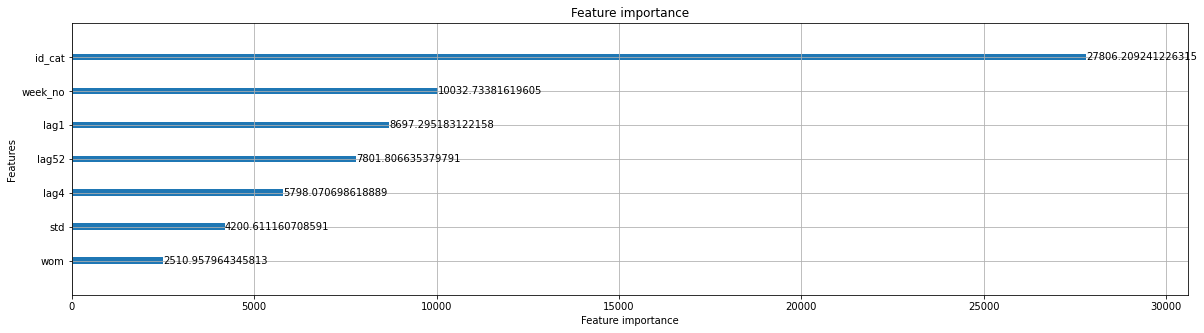

In [162]:
lgb.plot_importance(model,importance_type='gain',figsize=(20,5))

In [163]:
val_x1.head()

,week_no,wom,year,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,
2011-08-08,32,1,2011,83.487865,-0.597432,-0.597432,-0.375843,1.0
2011-08-15,33,2,2011,83.487865,-0.597432,-0.597432,-0.585454,1.0
2011-08-22,34,3,2011,83.487865,-0.597432,-0.597432,1.390881,1.0
2011-08-29,35,4,2011,83.487865,-0.597432,-0.597432,3.007883,1.0
2011-09-05,36,0,2011,83.487865,-0.597432,-0.597432,0.312880,1.0


In [164]:
val1['forecast'] = model.predict(val_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
train1['forecast'] = model.predict(train_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [166]:
train_val = pd.concat([train1,val1],axis=0)

In [167]:
vale = train_val.copy()
vale.head()

,StockCode,Quantity,week_no,wom,year,mean,std,tQuantity,lag1,lag4,lag52,forecast
ds,,,,,,,,,,,,
2011-01-03,10002,122.0,1,0,2011,49.878299,83.487865,0.863858,-0.597432,4.361373,4.804551,-0.141485
2011-01-10,10002,14.5,2,1,2011,49.878299,83.487865,-0.423754,0.863858,-0.375843,0.995614,-0.411508
2011-01-17,10002,27.0,3,2,2011,49.878299,83.487865,-0.274031,-0.423754,-0.573476,-0.214142,-0.264647
2011-01-24,10002,17.0,4,3,2011,49.878299,83.487865,-0.393809,-0.274031,-0.597432,-0.313957,-0.286790
2011-01-31,10002,66.0,5,4,2011,49.878299,83.487865,0.193102,-0.393809,0.863858,-0.557506,-0.361166


In [168]:
data1.shape

(332273, 9)

In [169]:
vale['forecast'].max()

1.799765434424432

In [170]:
vale = vale.reset_index()

In [171]:
for lag in range(2,5):
  vale['lag'+str(lag)] = vale.groupby(['StockCode'])['tQuantity'].shift(lag)

In [172]:
val_x1.columns

Index(['week_no', 'wom', 'year', 'std', 'lag1', 'lag4', 'lag52', 'id_cat'], dtype='object')

In [173]:
def recursive_forecast(val,data,model,id_encoder,forecast_range=7,var='Quantity'):
  dat = val.copy()
  dat1 =data.copy()
  colname= dat.columns.tolist()
  for lag in range(2,5):
    dat['lag'+str(lag)] = dat.groupby(['StockCode'])[var].shift(lag)
  
  dat = dat.groupby(['StockCode'])[colname].tail(1).reset_index()
  da = dat.copy()
  da_f = pd.DataFrame()  
  for fr in range(1,forecast_range):
    
    da['ds'] = da['ds'] + pd.DateOffset(days=7)
    if fr < 5:
      for i in range(1,5):
        if i == 1:
          da['lag'+str(i)] = dat['forecast'].values
                   
        else:
          da['lag'+str(i+1)] = dat['lag'+str(i)].values
          
        if i == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          print(datt)
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          # print(dat12)
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] = datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          # print(da)

          da['lag52'] = da11['lag52']
          
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          
          da1 = da[['week_no', 'wom', 'year', 'std', 'lag1', 'lag4', 'lag52', 'id_cat']]
          
          da.loc[:,'forecast'] = model.predict(da1)
      da_f = pd.concat([da_f,da],axis=0)
    
    else:
      for j in range(1,5):
        if j == 1 :
          da['lag'+str(j)] = da['forecast']
          
        elif j < 5:
          # print(da['lag'+str(j+1)])
          da['lag'+str(j+1)] = da['lag'+str(j)]
        if j == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          # print(datt,'\n',da['ds'])
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] =datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          # da11 = da11.rename(columns={})
          print(da11)
          da['lag52'] = da11['lag52']
          # print(da)
          # print(da['lag365'])
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          da1 = da[['week_no', 'wom', 'year', 'std', 'lag1', 'lag4', 'lag52', 'id_cat']]
          # print(da1)
          # print(da1.head())
          da.loc[:,'forecast'] = model.predict(da1)
      da_f = pd.concat([da_f,da],axis=0)
  return da_f
 

In [174]:
fr = recursive_forecast(vale,data1,model,id_encoder,8,'tQuantity')

0      2010-09-20
1      2010-09-20
2      2010-09-20
3      2010-09-20
4      2010-09-20
          ...    
3259   2010-09-20
3260   2010-09-20
3261   2010-09-20
3262   2010-09-20
3263   2010-09-20
Name: ds, Length: 3264, dtype: datetime64[ns]
0      2010-09-27
1      2010-09-27
2      2010-09-27
3      2010-09-27
4      2010-09-27
          ...    
3259   2010-09-27
3260   2010-09-27
3261   2010-09-27
3262   2010-09-27
3263   2010-09-27
Name: ds, Length: 3264, dtype: datetime64[ns]
0      2010-10-04
1      2010-10-04
2      2010-10-04
3      2010-10-04
4      2010-10-04
          ...    
3259   2010-10-04
3260   2010-10-04
3261   2010-10-04
3262   2010-10-04
3263   2010-10-04
Name: ds, Length: 3264, dtype: datetime64[ns]
0      2010-10-11
1      2010-10-11
2      2010-10-11
3      2010-10-11
4      2010-10-11
          ...    
3259   2010-10-11
3260   2010-10-11
3261   2010-10-11
3262   2010-10-11
3263   2010-10-11
Name: ds, Length: 3264, dtype: datetime64[ns]
           ds52     Stoc

In [179]:
data1.shape

(332273, 9)

In [175]:
fr.head()

,index,ds,StockCode,Quantity,week_no,wom,year,mean,std,tQuantity,lag1,lag4,lag52,forecast,lag2,lag3,lag5,ds52,id_cat
0,99040,2011-09-19,10002,0.0,37,1,2011,49.878299,83.487865,-0.597432,-0.409065,-0.597432,0.181125,-0.382986,-0.597432,-0.597432,-0.597432,2010-09-20,1.0
1,99046,2011-09-19,10080,0.0,37,1,2011,4.052083,14.317725,-0.283012,0.039809,0.555110,-0.283012,0.180329,-0.283012,-0.283012,-0.283012,2010-09-20,2.0
2,99052,2011-09-19,10120,0.0,37,1,2011,4.473958,10.544984,-0.424274,-0.236921,2.420681,-0.424274,-0.134350,-0.424274,-0.424274,-0.424274,2010-09-20,3.0
3,99058,2011-09-19,10123C,0.0,37,1,2011,3.125000,15.025942,-0.207974,-0.222756,-0.207974,-0.207974,-0.236117,-0.207974,-0.207974,-0.207974,2010-09-20,4.0
4,99064,2011-09-19,10124A,0.0,37,1,2011,1.413043,8.005702,-0.176505,-0.282133,-0.176505,0.198228,-0.273488,-0.176505,-0.176505,-0.176505,2010-09-20,5.0


In [176]:
test = test.reset_index()

In [ ]:
test1 = test.merge(fr[['StockCode','ds','forecast']],on=['StockCode','ds'],how='left')

In [ ]:
test1['forecast'] = test1['forecast']*test1['std'] + test1['mean']

In [ ]:
test1['error'] = np.abs(test1['Quantity']-test1['forecast'])/(test1['Quantity']+1)

In [ ]:
t2 = test1.loc[test1['Quantity']>0,]

In [ ]:
t = test1.groupby('StockCode')['error'].mean().reset_index()

In [ ]:
t = t.sort_values(by=['error'])

In [180]:
t2.groupby('StockCode')['error'].mean().mean()

0.885968185357268

In [ ]:
t3

In [ ]:
test1.to_csv('../../data/stock_lgb_weekly.csv')

In [ ]:
t['StockCode'].head(60).tolist()

['21335',
 '84532B',
 '84782A',
 '85225',
 'DCGS0076',
 '90187A',
 '84845C',
 '90128D',
 'gift_0001_50',
 '85136B',
 '37506',
 '21752',
 '85112',
 '90002C',
 '90024B',
 '84533B',
 '20913',
 '90011E',
 '84948',
 '84613A',
 '90027D',
 '90013D',
 '46775E',
 '90195B',
 '84405A',
 '90156',
 '20804',
 '84664',
 '21299',
 '90176C',
 '84247C',
 '20787',
 '90211B',
 '84824',
 '90196B',
 '84578',
 '85090',
 '90027B',
 '90211A',
 '90100',
 '90083',
 '90171',
 '90037A',
 '20689',
 '82585',
 '85117',
 '90196A',
 '47570b',
 '21836',
 '90014C',
 '20672',
 '84902',
 '90099',
 '90026D',
 '84007',
 '21477',
 '84823',
 '79072',
 '37422',
 '21085']

In [ ]:
for i in t3['StockCode'].head(60).tolist():
  fig, ax = plt.subplots(figsize=(20,10))
  test1.loc[test1['StockCode']==i,'forecast'].plot(ax=ax,title=i)
  test1.loc[test1['StockCode']==i,'Quantity'].plot(ax=ax,title=i)

Output hidden; open in https://colab.research.google.com to view.